
Anggota		:  

[202210370311237 – Dimas Arief Wicaksono]

[202210370311236 – Muhammad Ikbar Ananda Sulistio]

[202210370311260 – Rofiq Samanhudi]




# Tahap 3-4: Data Pre-processing & Transformation


In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import combinations
from sklearn.cluster import DBSCAN

# Set random seed untuk reproduktibilitas
np.random.seed(42)

In [ ]:
# -----------------------------------------------
# 1. MEMUAT DATASET
# -----------------------------------------------
# Memuat dataset food-nutrition-dataset dari Kaggle
print("Memuat Dataset food-nutrition-dataset dari Kaggle")

# Instal dependensi sesuai kebutuhan
# !pip install kagglehub[pandas-datasets]

# Download dataset
dataset_path = kagglehub.dataset_download("shrutisaxena/food-nutrition-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# Tampilkan daftar file di direktori dataset untuk mengonfirmasi file yang tersedia
print("Files in dataset directory:", os.listdir(dataset_path))

# Tentukan jalur file (menggunakan nama file yang benar)
file_path = "food.csv"

# Muat dataset sebagai DataFrame pandas
data_makanan = pd.read_csv(f"{dataset_path}/{file_path}")

Memuat Dataset food-nutrition-dataset dari Kaggle
Dataset downloaded to: /kaggle/input/food-nutrition-dataset
Files in dataset directory: ['food.csv', 'food1.csv']


In [ ]:
# -----------------------------------------------
# 2. TARGET DATA
# -----------------------------------------------
# Memilih 12 atribut nutrisi yang relevan sesuai laporan
# Atribut ini akan digunakan untuk clustering berdasarkan kandungan nutrisi
kolom_fitur = [
    'Data.Carbohydrate', 'Data.Protein', 'Data.Fat.Total Lipid', 'Data.Kilocalories',
    'Data.Fiber', 'Data.Sugar Total', 'Data.Major Minerals.Calcium',
    'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin C',
    'Data.Vitamins.Vitamin E', 'Data.Major Minerals.Sodium',
    'Data.Cholesterol'
]

# Membuat salinan DataFrame dengan hanya kolom yang dipilih
data_pilih_fitur = data_makanan[kolom_fitur].copy()
print(f"Ukuran dataset setelah pemilihan fitur: {data_pilih_fitur.shape} (baris, kolom)")

# Menyimpan kolom 'Description' untuk interpretasi hasil klasterisasi nanti
data_deskripsi = data_makanan[['Description']].copy()


Ukuran dataset setelah pemilihan fitur: (7413, 12) (baris, kolom)


In [ ]:
# -----------------------------------------------
# 3. PEMBERSIHAN DATA
# -----------------------------------------------
# Mengonversi semua kolom ke tipe numerik, nilai non-numerik menjadi NaN
print("Mengonversi kolom ke tipe numerik...")
for kolom in data_pilih_fitur.columns:
    data_pilih_fitur[kolom] = pd.to_numeric(data_pilih_fitur[kolom], errors='coerce')

# Menghapus baris dengan nilai NaN (data hilang)
data_bersih = data_pilih_fitur.dropna()
print(f"Ukuran dataset setelah menghapus NaN: {data_bersih.shape} (baris, kolom)")

# Menghapus baris dengan nilai negatif, karena nutrisi tidak boleh negatif
data_bersih = data_bersih[(data_bersih >= 0).all(axis=1)]
print(f"Ukuran dataset setelah menghapus nilai negatif: {data_bersih.shape} (baris, kolom)")

# Menghapus baris duplikat untuk menghindari redundansi
data_bersih = data_bersih.drop_duplicates()
print(f"Ukuran dataset setelah menghapus duplikat: {data_bersih.shape} (baris, kolom)")

Mengonversi kolom ke tipe numerik...
Ukuran dataset setelah menghapus NaN: (7413, 12) (baris, kolom)
Ukuran dataset setelah menghapus nilai negatif: (7413, 12) (baris, kolom)
Ukuran dataset setelah menghapus duplikat: (7300, 12) (baris, kolom)


In [ ]:
# -----------------------------------------------
# 4. TRANSFORMASI DATA
# -----------------------------------------------
# Menangani outlier dengan membatasi nilai pada persentil ke-99
# Ini dilakukan untuk mengurangi dampak nilai ekstrem tanpa menghapus data
print("Menangani outlier dengan pembatasan pada persentil ke-99...")
for kolom in data_bersih.columns:
    batas_atas = data_bersih[kolom].quantile(0.99)  # Batas pada persentil ke-99
    data_bersih[kolom] = data_bersih[kolom].clip(upper=batas_atas)

Menangani outlier dengan pembatasan pada persentil ke-99...


### Normalisasi Data menggunakan Min-Max Scaling

In [ ]:
# -----------------------------------------------
# 5. NORMALISASI DATA (Min-Max Scaling)
# -----------------------------------------------
# Menerapkan Min-Max scaling untuk mengubah skala data ke rentang [0, 1]
# Normalisasi penting agar semua fitur memiliki kontribusi yang sama dalam clustering
print("Melakukan normalisasi data dengan Min-Max scaling...")

# Menampilkan 5 baris pertama data sebelum normalisasi
print("\nData sebelum normalisasi (5 baris pertama):")
pd.options.display.float_format = '{:.2f}'.format  # Membatasi 2 desimal untuk keterbacaan
print(data_bersih.head())

# Melakukan normalisasi menggunakan MinMaxScaler
pengskala = MinMaxScaler()
data_normalisasi = pengskala.fit_transform(data_bersih)
data_normalisasi = pd.DataFrame(data_normalisasi, columns=data_bersih.columns)

# Menampilkan 5 baris pertama data setelah normalisasi
print("\nData setelah normalisasi (5 baris pertama):")
print(data_normalisasi.head())

print(f"Ukuran dataset setelah normalisasi: {data_normalisasi.shape} (baris, kolom)")

# Menyimpan dataset yang sudah dinormalisasi ke file CSV
data_normalisasi.to_csv('makanan_preprocessed.csv', index=False)
print("Dataset yang dinormalisasi disimpan sebagai 'makanan_preprocessed.csv'")

Melakukan normalisasi data dengan Min-Max scaling...

Data sebelum normalisasi (5 baris pertama):
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Kilocalories  \
0               0.06          0.85                 81.11             717.00   
1               0.06          0.85                 81.11             717.00   
2               0.00          0.28                 99.48             876.00   
3               2.34         21.40                 28.74             353.00   
4               2.79         23.24                 29.68             371.00   

   Data.Fiber  Data.Sugar Total  Data.Major Minerals.Calcium  \
0        0.00              0.06                           24   
1        0.00              0.06                           24   
2        0.00              0.00                            4   
3        0.00              0.50                          528   
4        0.00              0.51                          674   

   Data.Major Minerals.Iron  Data.Vitamins

### Normalisasi Data menggunakan Z-Score

In [ ]:
# -----------------------------------------------
# 5. NORMALISASI DATA (Z-Score)
# -----------------------------------------------
# Menerapkan Z-score standardization untuk mengubah data sehingga memiliki mean=0 dan std=1
# Standarisasi penting agar semua fitur memiliki kontribusi yang sama dalam clustering
print("Melakukan normalisasi data dengan Z-score standardization...")

# Menampilkan 5 baris pertama data sebelum normalisasi
print("\nData sebelum normalisasi (5 baris pertama):")
pd.options.display.float_format = '{:.2f}'.format  # Membatasi 2 desimal untuk keterbacaan
print(data_bersih.head())

# Melakukan normalisasi menggunakan StandardScaler
from sklearn.preprocessing import StandardScaler
pengskala = StandardScaler()
data_normalisasiZScore = pengskala.fit_transform(data_bersih)
data_normalisasiZScore = pd.DataFrame(data_normalisasiZScore, columns=data_bersih.columns)

# Menampilkan 5 baris pertama data setelah normalisasi
print("\nData setelah normalisasi (5 baris pertama):")
print(data_normalisasiZScore.head())

print(f"Ukuran dataset setelah normalisasi: {data_normalisasiZScore.shape} (baris, kolom)")

# Menyimpan dataset yang sudah dinormalisasi ke file CSV
data_normalisasiZScore.to_csv('makanan_preprocessed_zscore.csv', index=False)
print("Dataset yang dinormalisasi disimpan sebagai 'makanan_preprocessed_zscore.csv'")

Melakukan normalisasi data dengan Z-score standardization...

Data sebelum normalisasi (5 baris pertama):
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Kilocalories  \
0               0.06          0.85                 81.11             717.00   
1               0.06          0.85                 81.11             717.00   
2               0.00          0.28                 99.48             876.00   
3               2.34         21.40                 28.74             353.00   
4               2.79         23.24                 29.68             371.00   

   Data.Fiber  Data.Sugar Total  Data.Major Minerals.Calcium  \
0        0.00              0.06                           24   
1        0.00              0.06                           24   
2        0.00              0.00                            4   
3        0.00              0.50                          528   
4        0.00              0.51                          674   

   Data.Major Minerals.Iron  Data.

In [ ]:
# -----------------------------------------------
# 6. RINGKASAN
# -----------------------------------------------
print("\nRingkasan Proses Pre-processing:")
print(f"- Ukuran dataset awal: {data_makanan.shape}")
print(f"- Ukuran setelah pemilihan fitur: {data_pilih_fitur.shape}")
print(f"- Ukuran setelah pembersihan (NaN, negatif, duplikat): {data_bersih.shape}")
print(f"- Ukuran setelah normalisasi Min-Max Scaling: {data_normalisasi.shape}")
print(f"- Ukuran setelah normalisasi Z-Score: {data_normalisasiZScore.shape}")


Ringkasan Proses Pre-processing:
- Ukuran dataset awal: (7413, 48)
- Ukuran setelah pemilihan fitur: (7413, 12)
- Ukuran setelah pembersihan (NaN, negatif, duplikat): (7300, 12)
- Ukuran setelah normalisasi Min-Max Scaling: (7300, 12)
- Ukuran setelah normalisasi Z-Score: (7300, 12)


# Tahap 5: Data Mining

## 1. Data Mining Menggunakan K-Means (normalisasi Min-Max Scaling)

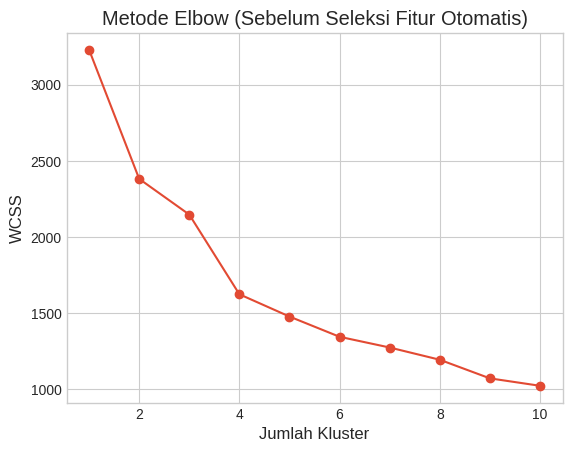

In [ ]:
# ---------------------------------------------------------
# 1. VALIDASI JUMLAH KLASTER (METODE ELBOW)
# ---------------------------------------------------------

# Inisialisasi list untuk menyimpan nilai WCSS (Within-Cluster Sum of Square)
wcss = []

# Melakukan iterasi untuk berbagai jumlah klaster dari 1 hingga 10
for i in range(1, 11):
    # Inisialisasi dan pelatihan model KMeans
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_normalisasi)

    # Menyimpan nilai inertia (WCSS) untuk jumlah klaster saat ini
    wcss.append(kmeans.inertia_)

# ---------------------------------------------------------
# 2. VISUALISASI METODE ELBOW
# ---------------------------------------------------------

# Membuat plot jumlah klaster vs nilai WCSS
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Metode Elbow (Sebelum Seleksi Fitur Otomatis)')
plt.xlabel('Jumlah Klaster')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [ ]:
# Asumsi data_normalisasi sudah didefinisikan
# Inisialisasi model KMeans dan klasterisasi (dari kode Anda)
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_normalisasi)  # Menggunakan seluruh data_normalisasi

# Total sampel diambil langsung dari data_normalisasi
n_samples = len(data_normalisasi)

# 1. Distribusi klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# Inertia: total jarak dalam klaster
inertia = kmeans_final.inertia_

# Silhouette Score: seberapa baik objek cocok dengan klasternya
silhouette_final = silhouette_score(data_normalisasi, clusters_final)

# Davies-Bouldin Index: semakin rendah, semakin baik pemisahan antar klaster
db_index_final = davies_bouldin_score(data_normalisasi, clusters_final)

print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Hitung jarak setiap titik ke pusat klasternya (jarak minimum)
distances = np.min(kmeans_final.transform(data_normalisasi), axis=1)

# Threshold: ambil 5% dengan jarak terjauh sebagai outlier
threshold = np.percentile(distances, 95)

# Identifikasi indeks data yang merupakan outlier
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)

print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)")


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 2435 sampel (33.36%)
Klaster 1: 1595 sampel (21.85%)
Klaster 2: 272 sampel (3.73%)
Klaster 3: 2998 sampel (41.07%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 1621.964
Silhouette Score: 0.353
Davies-Bouldin Index: 1.127

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 70 outlier (2.87% dari klaster)
Klaster 1: 235 outlier (14.73% dari klaster)
Klaster 2: 18 outlier (6.62% dari klaster)
Klaster 3: 42 outlier (1.40% dari klaster)


In [ ]:
# Asumsi:
# - data_normalisasi: dataset yang sudah dinormalisasi
# - data_bersih: dataset asli sebelum normalisasi (digunakan untuk menampilkan informasi deskriptif)
# - kmeans_final: model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_normalisasi), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_normalisasi)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")

# Jika ada outlier, tampilkan detail setiap instance
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]

        # Ambil nama item dari kolom 'Description' jika tersedia, jika tidak beri label generik
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]

        # Cetak informasi indeks, nama, klaster, dan jarak ke centroid
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    # Jika tidak ada outlier ditemukan
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 22, Nama Item: Item_22, Klaster: 0, Jarak ke Centroid: 1.018
Index: 31, Nama Item: Item_31, Klaster: 0, Jarak ke Centroid: 1.215
Index: 32, Nama Item: Item_32, Klaster: 0, Jarak ke Centroid: 1.219
Index: 37, Nama Item: Item_37, Klaster: 0, Jarak ke Centroid: 1.100
Index: 38, Nama Item: Item_38, Klaster: 0, Jarak ke Centroid: 1.020
Index: 43, Nama Item: Item_43, Klaster: 0, Jarak ke Centroid: 0.958
Index: 46, Nama Item: Item_46, Klaster: 0, Jarak ke Centroid: 0.963
Index: 82, Nama Item: Item_82, Klaster: 1, Jarak ke Centroid: 1.166
Index: 83, Nama Item: Item_83, Klaster: 1, Jarak ke Centroid: 1.307
Index: 84, Nama Item: Item_84, Klaster: 1, Jarak ke Centroid: 1.292
Index: 85, Nama Item: Item_85, Klaster: 0, Jarak ke Centroid: 1.138
Index: 86, Nama Item: Item_86, Klaster: 1, Jarak ke Centroid: 1.275
Index: 101, Nama Item: Item_101, Klaster: 1, Jarak ke Centroid: 1.184
Index: 103, Nama Item: Item_103, Klaster: 1, 

### Feature Selection menggunakan Silhouette dan DBI

In [ ]:
# ------------------------------
# 3. FEATURE SELECTION
# ------------------------------

#Fungsi untuk mengevaluasi pentingnya setiap fitur berdasarkan dampaknya terhadap metrik klastering
def evaluate_features(data, n_clusters=4):
    # -----------------------------------------------------
    # 1. Evaluasi baseline (menggunakan semua fitur)
    # -----------------------------------------------------
    baseline_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    baseline_labels = baseline_kmeans.labels_
    baseline_sil = silhouette_score(data, baseline_labels)
    baseline_db = davies_bouldin_score(data, baseline_labels)

    print(f"Baseline (Semua fitur) -> Silhouette: {baseline_sil:.3f}, Davies-Bouldin: {baseline_db:.3f}")

    result = []
    for fitur in data.columns:
        # Hapus satu fitur dan latih ulang KMeans
        subset = data.drop(columns=[fitur])
        labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(subset)

        # Hitung metrik klaster untuk subset
        sil = silhouette_score(subset, labels)
        db = davies_bouldin_score(subset, labels)

        # Simpan hasil perbandingan
        result.append({
            'fitur_dihapus': fitur,
            'silhouette': sil,
            'davies_bouldin': db,
            'delta_silhouette': sil - baseline_sil,
            'delta_db': db - baseline_db
        })

    # Kembalikan hasil sebagai DataFrame, diurutkan berdasarkan peningkatan silhouette tertinggi
    return pd.DataFrame(result).sort_values(by='delta_silhouette', ascending=False)

# Jalankan evaluasi otomatis
hasil_evaluasi = evaluate_features(data_normalisasi)

# Ambil fitur yang jika dihapus meningkatkan Silhouette & menurunkan DB Index
fitur_dihapus_otomatis = hasil_evaluasi[
    (hasil_evaluasi['delta_silhouette'] > 0) &
    (hasil_evaluasi['delta_db'] < 0)
]['fitur_dihapus'].tolist()

# Simpan data dengan fitur terbaik
fitur_final = [f for f in data_normalisasi.columns if f not in fitur_dihapus_otomatis]
data_final = data_normalisasi[fitur_final]

# Tampilkan hasil akhir dari proses seleksi fitur
print(f"\nFitur yang dihapus otomatis: {fitur_dihapus_otomatis}")
print(f"Jumlah fitur tersisa: {len(fitur_final)}")

Baseline (Fitur pilihan) -> Silhouette: 0.353, Davies-Bouldin: 1.127

Fitur yang dihapus otomatis: ['Data.Major Minerals.Sodium', 'Data.Vitamins.Vitamin C', 'Data.Sugar Total', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin E']
Jumlah fitur tersisa: 6


In [ ]:
# -----------------------------------------------
# 4. TERAPKAN K-MEANS DENGAN k=4 (FITUR TERPILIH)
# -----------------------------------------------
# Terapkan KMeans pada data hasil seleksi fitur
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=42)
clusters = kmeans.fit_predict(data_final)  # data_final = hasil seleksi fitur

# -----------------------------------------------
# 5. TAMBAHKAN LABEL KLASTER KE DATASET BERSIH
# -----------------------------------------------
data_bersih['Cluster'] = clusters

# -----------------------------------------------
# 6. SIMPAN DATASET DENGAN LABEL KLASTER
# -----------------------------------------------
data_bersih.to_csv('makanan_clustered.csv', index=False)
print("Dataset dengan label klaster disimpan sebagai 'makanan_clustered.csv'")

Dataset dengan label klaster disimpan sebagai 'makanan_clustered.csv'


In [ ]:
# -----------------------------------------------
# 7. HITUNG JUMLAH DATA PER KLASTER
# -----------------------------------------------

# Menghitung jumlah sampel dalam setiap klaster
cluster_counts = data_bersih['Cluster'].value_counts().sort_index()

# Menampilkan hasil
print("\nJumlah Data per Klaster:")
print(cluster_counts)


Jumlah Data per Klaster:
Cluster
0    1619
1    3014
2    2394
3     273
Name: count, dtype: int64


In [ ]:
# -----------------------------------------------
# 8. ANALISIS CENTROID
# -----------------------------------------------

# Ambil nama kolom dari data_final (hasil feature selection)
kolom_fitur = data_final.columns

# Jalankan kembali KMeans pada data_final (pastikan modelnya sesuai)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(data_final)

# Simpan ke data_bersih
data_bersih['Cluster'] = clusters

# Ambil nilai centroid
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=kolom_fitur)

print("\nNilai Centroid untuk Setiap Klaster:")
print(centroid_df)


Nilai Centroid untuk Setiap Klaster:
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Kilocalories  \
0               0.03          0.62                  0.12               0.24   
1               0.15          0.09                  0.03               0.10   
2               0.76          0.22                  0.10               0.43   
3               0.10          0.23                  0.71               0.78   

   Data.Fiber  Data.Cholesterol  
0        0.01              0.24  
1        0.07              0.02  
2        0.23              0.02  
3        0.14              0.09  


<ipython-input-578-fa0b7c484a28>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(kolom_fitur))


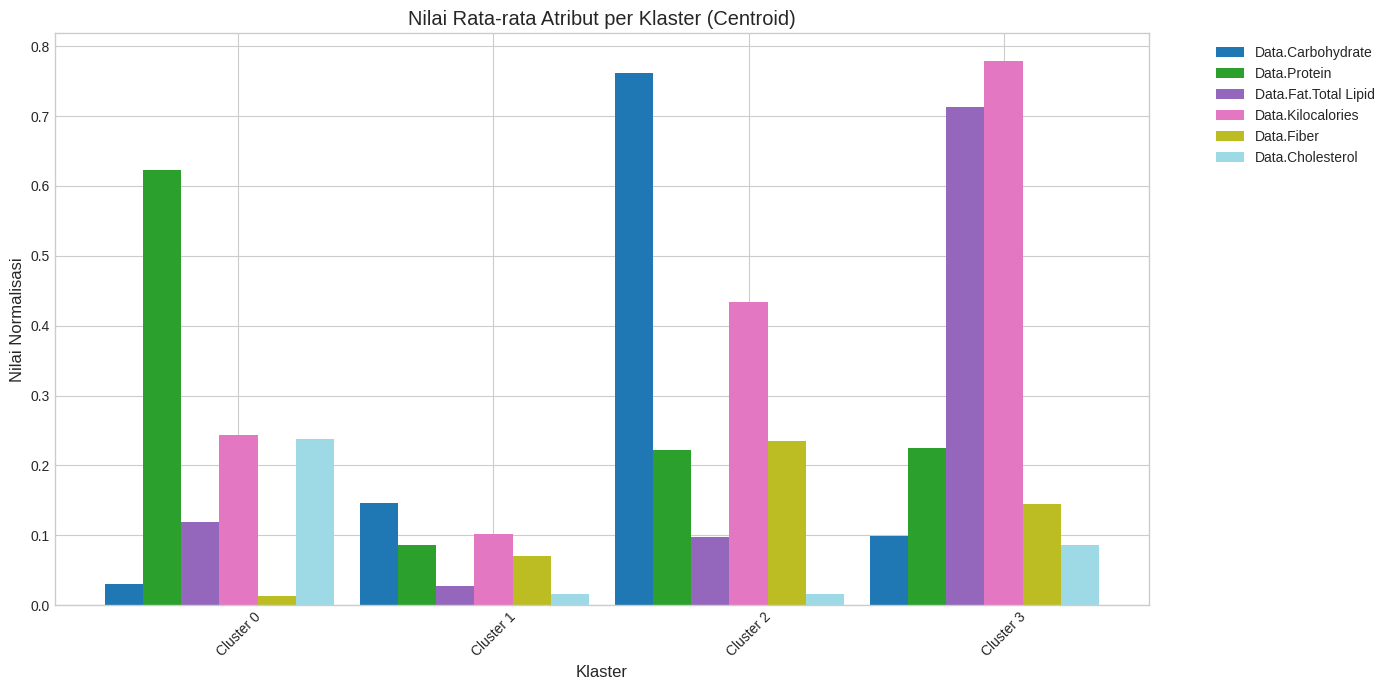

In [ ]:
# -----------------------------------------------
# 9. VISUALISASI CENTROID DENGAN BAR PLOT
# -----------------------------------------------
# Inisialisasi ukuran figure untuk tampilan yang lebih lebar
plt.figure(figsize=(14, 7))

# Jumlah klaster berdasarkan baris centroid
num_clusters = len(centroid_df)

# Skema warna: menggunakan colormap tab20 dan jumlah fitur sebagai parameter
colors = plt.cm.get_cmap('tab20', len(kolom_fitur))

# Lebar bar disesuaikan agar semua fitur muat dalam satu klaster
bar_width = 0.9 / len(kolom_fitur)

for i, col in enumerate(kolom_fitur):
    # Set posisi bar bergeser agar tidak menumpuk di tengah
    plt.bar(np.arange(num_clusters) + i * bar_width,
            centroid_df[col],                   # Nilai centroid per fitur
            width=bar_width,
            label=col,                          # Label legenda
            color=colors(i))                    # Warna unik per fitur

plt.xticks(
    np.arange(num_clusters) + bar_width * (len(kolom_fitur) / 2),
    [f'Cluster {i}' for i in range(num_clusters)],  # Label klaster
    rotation=45
)

plt.title('Nilai Rata-rata Atribut per Klaster (Centroid)')
plt.xlabel('Klaster')
plt.ylabel('Nilai Normalisasi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Letakkan legenda di luar grafik
plt.tight_layout()  # Otomatis sesuaikan layout agar tidak terpotong
plt.show()

<ipython-input-579-5f231ac3fb6c>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))


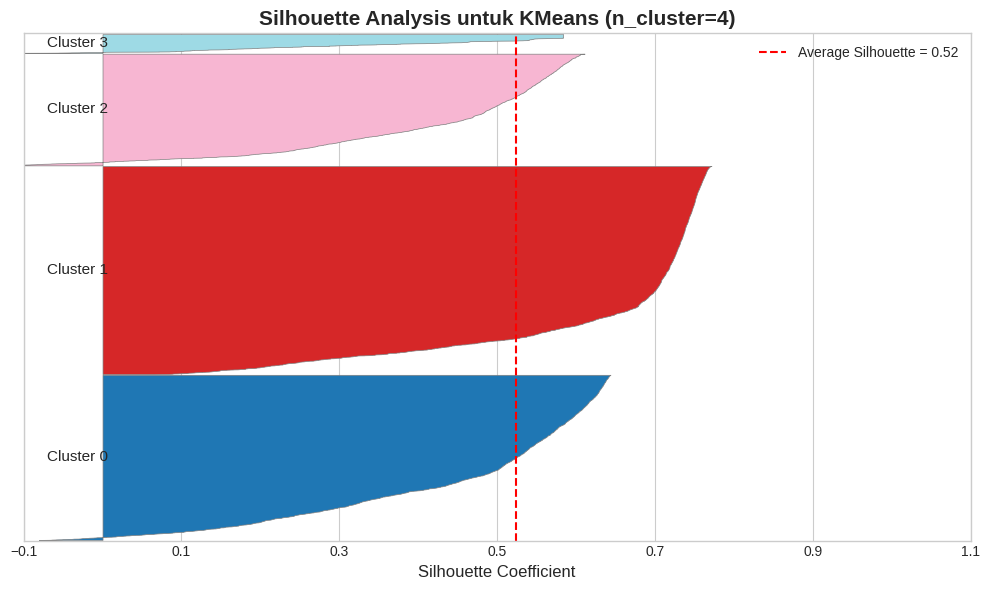

In [ ]:
# -----------------------------------------------
# 10. HITUNG SILHOUETTE SCORE (gunakan data_final)
# -----------------------------------------------
# Hitung nilai rata-rata Silhouette Score secara keseluruhan
silhouette_avg = silhouette_score(data_final, clusters)

# Hitung nilai Silhouette Score per sampel
silhouette_vals = silhouette_samples(data_final, clusters)

# -----------------------------------------------
# 11. VISUALISASI SILHOUETTE PLOT
# -----------------------------------------------
# Gunakan style seaborn untuk tampilan yang bersih
plt.style.use('seaborn-v0_8-whitegrid')

# Inisialisasi figure dan axes
fig, ax = plt.subplots(figsize=(10, 6))

# Tentukan jumlah klaster (harus konsisten dengan `clusters`)
n_clusters = 4
y_lower = 10  # Titik awal sumbu Y untuk menumpuk bar

# Ambil skema warna untuk visualisasi
colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))

# ---------------------------------------------------------
# Plot Silhouette untuk setiap klaster
# ---------------------------------------------------------
for i in range(n_clusters):
    # Ambil dan urutkan nilai silhouette untuk klaster ke-i
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    # Hitung ukuran dan batas atas segmen untuk klaster ini
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Visualisasikan nilai silhouette sebagai area (bar horizontal)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i],
                     edgecolor='gray',
                     linewidth=0.5)

    # Tambahkan label klaster di tengah bloknya
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {i}', fontsize=11,
            verticalalignment='center')

    # Update posisi Y untuk klaster berikutnya
    y_lower = y_upper + 10  # Tambah spasi antar klaster

# ---------------------------------------------------------
# Tambahkan garis vertikal untuk rata-rata silhouette
# ---------------------------------------------------------
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# ---------------------------------------------------------
# Format visualisasi
# ---------------------------------------------------------
ax.set_title('Silhouette Analysis untuk KMeans (n_cluster=4)', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Batas dan skala sumbu
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final) + (n_clusters + 1) * 10])
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Tampilkan legenda
ax.legend(loc='upper right', fontsize=10)

# Atur layout agar tidak terpotong
plt.tight_layout()
plt.show()


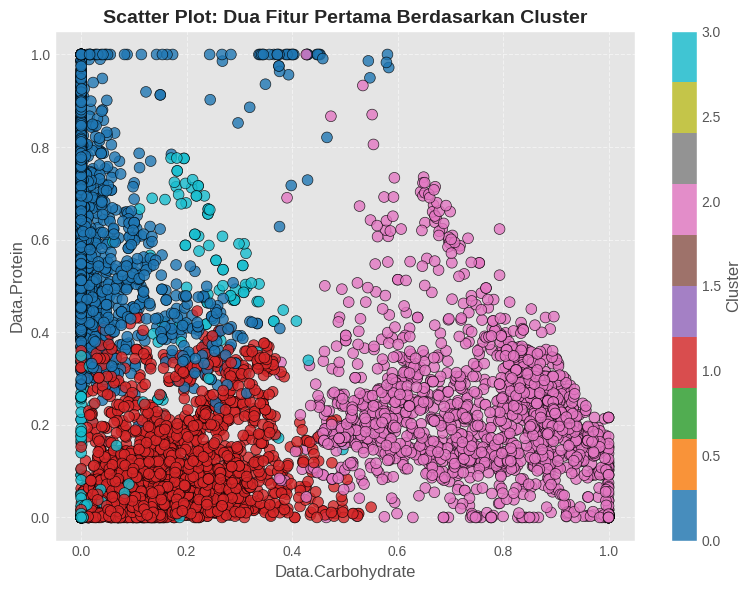

In [ ]:
# ---------------------------------------------------------
# 12. SCATTER PLOT UNTUK 2 FITUR PERTAMA (dari data_final)
# ---------------------------------------------------------

# Ambil dua fitur pertama dari data_final untuk visualisasi 2D
x = data_final.iloc[:, 0]
y = data_final.iloc[:, 1]

# Atur style visualisasi menggunakan 'ggplot' agar tampilannya lebih estetik
plt.style.use('ggplot')

# Inisialisasi ukuran canvas plotting
plt.figure(figsize=(8, 6))

# Buat scatter plot dengan pewarnaan berdasarkan label klaster
scatter = plt.scatter(
    x, y,
    c=clusters,              # Warna berdasarkan hasil klaster
    cmap='tab10',            # Skema warna 10 kategori
    edgecolor='black',       # Garis tepi tiap titik
    s=60,                    # Ukuran titik
    alpha=0.8                # Transparansi titik
)

# Label sumbu X dan Y diambil dari nama kolom asli
plt.xlabel(data_final.columns[0], fontsize=12)
plt.ylabel(data_final.columns[1], fontsize=12)

# Judul plot
plt.title('Scatter Plot: Dua Fitur Pertama Berdasarkan Cluster', fontsize=14, fontweight='bold')

# Tambahkan colorbar sebagai legenda klaster
plt.colorbar(scatter, label='Cluster')

# Tambahkan grid garis bantu untuk kemudahan membaca
plt.grid(True, linestyle='--', alpha=0.5)

# Otomatis atur layout agar elemen tidak tumpang tindih
plt.tight_layout()

# Tampilkan plot
plt.show()


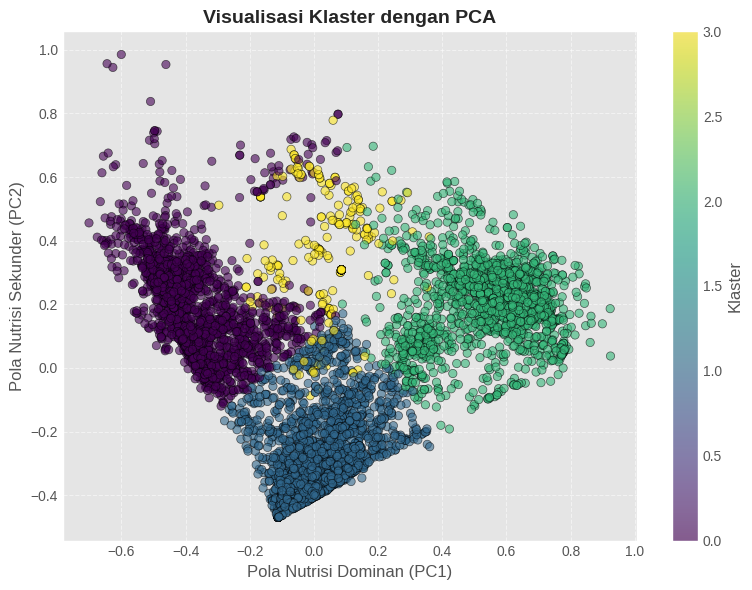

Variansi dijelaskan oleh PCA: 0.7382


In [ ]:
# ---------------------------------------------------------
# 13. VISUALISASI KLASTER DENGAN PCA
# ---------------------------------------------------------

# Lakukan reduksi dimensi ke 2 komponen utama menggunakan PCA
# Input: data_final (sudah melalui seleksi fitur dan normalisasi)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_final)  # Hasil transformasi berbentuk array 2D (n_samples x 2)

# ---------------------------------------------------------
# 14. BUAT SCATTER PLOT HASIL PCA
# ---------------------------------------------------------

# Inisialisasi figure untuk scatter plot
plt.figure(figsize=(8, 6))

# Buat scatter plot dengan dua principal components sebagai sumbu X dan Y
scatter = plt.scatter(
    data_pca[:, 0], data_pca[:, 1],  # Sumbu X: PC1, Sumbu Y: PC2
    c=clusters,                      # Warna berdasarkan hasil klaster KMeans
    cmap='viridis',                 # Skema warna bergradasi
    alpha=0.6,                      # Transparansi titik
    edgecolors='k'                  # Warna tepi hitam untuk tiap titik
)

# Tambahkan judul dan label sumbu
plt.title('Visualisasi Klaster dengan PCA', fontsize=14, fontweight='bold')
plt.xlabel('Pola Nutrisi Dominan (PC1)', fontsize=12)
plt.ylabel('Pola Nutrisi Sekunder (PC2)', fontsize=12)

# Tambahkan colorbar sebagai indikator klaster
plt.colorbar(scatter, label='Klaster')

# Tambahkan grid bantu untuk kemudahan membaca
plt.grid(True, linestyle='--', alpha=0.5)

# Atur layout agar tidak ada elemen yang terpotong
plt.tight_layout()

# Tampilkan plot
plt.show()

# Tampilkan proporsi variansi yang dijelaskan oleh dua komponen utama
print(f"Variansi dijelaskan oleh PCA: {pca.explained_variance_ratio_.sum():.4f}")


In [ ]:
# ---------------------------------------------------------
# 16. EVALUASI ULANG SETELAH FITUR DIHAPUS
# ---------------------------------------------------------

# Inisialisasi ulang model KMeans dengan jumlah klaster yang sama (4 klaster)
kmeans_final = KMeans(n_clusters=4, random_state=42)

# Lakukan klasterisasi pada data_final (fitur hasil seleksi otomatis)
clusters_final = kmeans_final.fit_predict(data_final)

# Hitung metrik evaluasi klasterisasi:
# - Silhouette Score: mengukur seberapa baik pemisahan antar klaster
# - Davies-Bouldin Index: semakin kecil nilainya, semakin baik pemisahan antar klaster
silhouette_final = silhouette_score(data_final, clusters_final)
db_index_final = davies_bouldin_score(data_final, clusters_final)

# Cetak hasil evaluasi setelah fitur yang tidak relevan dihapus
print(f"\nSetelah seleksi fitur otomatis:")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")



Setelah seleksi fitur otomatis:
Silhouette Score: 0.524
Davies-Bouldin Index: 0.760


In [ ]:
# Setelah clustering
data_bersih['Cluster'] = kmeans.labels_

# Menambahkan kembali kolom 'Description' untuk interpretasi klaster
data_bersih['Description'] = data_deskripsi.loc[data_bersih.index, 'Description']

In [ ]:
# ---------------------------------------------------------
# 17. INTERPRETASI KUALITATIF: TAMPILAN CONTOH MAKANAN PER KLASTER
# ---------------------------------------------------------

# Ambil nama-nama kolom fitur yang digunakan setelah seleksi
kolom_fitur = data_final.columns.tolist()

# Tampilkan contoh data dari setiap klaster untuk interpretasi makna masing-masing klaster
print("\nContoh Makanan per Klaster:")
for cluster in range(4):  # Asumsi jumlah klaster = 4
    print(f"\nCluster {cluster}:")

    # Ambil subset dari data_bersih yang sudah diberi label klaster
    cluster_data = data_bersih[data_bersih['Cluster'] == cluster]

    # Tampilkan 5 contoh teratas dari kolom 'Description' dan fitur-fitur terpilih
    print(cluster_data[['Description'] + kolom_fitur].head(5))



Contoh Makanan per Klaster:

Cluster 0:
        Description  Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  \
3       CHEESE,BLUE               2.34         21.40                 28.74   
4      CHEESE,BRICK               2.79         23.24                 29.68   
5       CHEESE,BRIE               0.45         20.75                 27.68   
6  CHEESE,CAMEMBERT               0.46         19.80                 24.26   
7    CHEESE,CARAWAY               3.06         25.18                 29.20   

   Data.Kilocalories  Data.Fiber  Data.Cholesterol  
3             353.00        0.00             75.00  
4             371.00        0.00             94.00  
5             334.00        0.00            100.00  
6             300.00        0.00             72.00  
7             376.00        0.00             93.00  

Cluster 1:
                                         Description  Data.Carbohydrate  \
11               CHEESE,COTTAGE,CRMD,LRG OR SML CURD               3.38   
12        

In [ ]:
# Asumsi data_final sudah didefinisikan
# Inisialisasi model KMeans dan klasterisasi (dari kode Anda)
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_final)  # Menggunakan seluruh data_final

# Total sampel diambil langsung dari data_final
n_samples = len(data_final)

# 1. Distribusi klaster
# Hitung jumlah sampel per klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# Hitung inertia (total jarak intra-klaster)
inertia = kmeans_final.inertia_

# Hitung Silhouette Score: seberapa baik klaster terpisah satu sama lain (range -1 s.d. 1)
silhouette_final = silhouette_score(data_final, clusters_final)

# Hitung Davies-Bouldin Index: semakin kecil, semakin baik pemisahan antar klaster
db_index_final = davies_bouldin_score(data_final, clusters_final)

print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Hitung jarak tiap titik ke centroid klaster terdekat
distances = np.min(kmeans_final.transform(data_final), axis=1)

# Ambil threshold untuk outlier (misalnya top 5% berdasarkan jarak)
threshold = np.percentile(distances, 95)

# Identifikasi outlier berdasarkan threshold
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
# Hitung berapa outlier yang muncul di tiap klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)

print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)")


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 2393 sampel (32.78%)
Klaster 1: 3014 sampel (41.29%)
Klaster 2: 1619 sampel (22.18%)
Klaster 3: 274 sampel (3.75%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 592.560
Silhouette Score: 0.524
Davies-Bouldin Index: 0.760

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 159 outlier (6.64% dari klaster)
Klaster 1: 5 outlier (0.17% dari klaster)
Klaster 2: 141 outlier (8.71% dari klaster)
Klaster 3: 60 outlier (21.90% dari klaster)


In [ ]:
# Asumsi data_final dan data_bersih sudah didefinisikan
# Asumsi kmeans_final adalah model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_final), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_final)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 0, Nama Item: BUTTER,WITH SALT, Klaster: 3, Jarak ke Centroid: 0.592
Index: 1, Nama Item: BUTTER,WHIPPED,WITH SALT, Klaster: 3, Jarak ke Centroid: 0.602
Index: 2, Nama Item: BUTTER OIL,ANHYDROUS, Klaster: 3, Jarak ke Centroid: 0.780
Index: 51, Nama Item: CREAM,FLUID,HVY WHIPPING, Klaster: 1, Jarak ke Centroid: 0.599
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 0, Jarak ke Centroid: 0.546
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 0.721
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 0.709
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Klaster: 0, Jarak ke Centroid: 0.724
Index: 86, Nama Item: MILK,BUTTERMILK,DRIED, Klaster: 0, Jarak ke Centroid: 0.648
Index: 111, Nama Item: EGG,WHOLE,RAW,FRESH, Klaster: 0, Jarak ke Centroid: 0.815
Index: 113, Nama Item: EGG,YOLK,RAW,FRSH, Klaster: 0, Jarak ke Centroid: 0.807
Index: 114, Nama Item: EGG

### Feature Selection menggunakan Threshold Correlation

In [ ]:
# ------------------------------
# 3. FEATURE SELECTION: CORRELATION FILTERING DENGAN PENCARIAN THRESHOLD TERBAIK
# ------------------------------
def correlation_filtering_auto(data, thresholds=None, n_clusters=4):
    # Jika threshold tidak diberikan, gunakan default range dari 0.5 sampai 0.95
    if thresholds is None:
        thresholds = np.arange(0.5, 0.96, 0.05)

    hasil_evaluasi = []

    print("Mengevaluasi berbagai threshold korelasi...\n")
    for threshold in thresholds:
        # Hitung korelasi absolut antar fitur
        corr_matrix = data.corr().abs()

        # Ambil hanya segitiga atas (untuk menghindari duplikasi korelasi)
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Tandai fitur yang memiliki korelasi lebih besar dari threshold
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

        # Hapus fitur yang berkorelasi tinggi
        data_filtered = data.drop(columns=to_drop)

        # Evaluasi hasil clustering dengan KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data_filtered)

        # Hitung Silhouette dan Davies-Bouldin Index
        sil = silhouette_score(data_filtered, labels)
        db = davies_bouldin_score(data_filtered, labels)

        # Simpan hasil evaluasi untuk threshold saat ini
        hasil_evaluasi.append({
            'threshold': threshold,
            'n_features': data_filtered.shape[1],
            'n_dropped': len(to_drop),
            'silhouette': sil,
            'davies_bouldin': db
        })

        print(f"Threshold: {threshold:.2f} | Dropped: {len(to_drop)} | S: {sil:.3f} | DBI: {db:.3f}")

    # Konversi ke DataFrame
    df_eval = pd.DataFrame(hasil_evaluasi)

    # Ranking kombinasi terbaik dari Silhouette tinggi & DBI rendah
    df_eval['sil_rank'] = df_eval['silhouette'].rank(ascending=False)
    df_eval['dbi_rank'] = df_eval['davies_bouldin'].rank(ascending=True)
    df_eval['total_rank'] = df_eval['sil_rank'] + df_eval['dbi_rank']

    # Ambil threshold terbaik berdasarkan gabungan ranking
    best_threshold = df_eval.sort_values(by='total_rank').iloc[0]['threshold']
    print(f"\nThreshold terbaik berdasarkan gabungan metrik: {best_threshold:.2f}")

    # Terapkan threshold terbaik pada data awal
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
    data_normalisasi = data.drop(columns=to_drop)

    # Evaluasi akhir pada data hasil filter
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42)
    labels_final = kmeans_final.fit_predict(data_normalisasi)
    sil_final = silhouette_score(data_normalisasi, labels_final)
    db_final = davies_bouldin_score(data_normalisasi, labels_final)

    print(f"\nEvaluasi Akhir (Threshold = {best_threshold:.2f}):")
    print(f"Jumlah fitur tersisa: {data_normalisasi.shape[1]}")
    print(f"Silhouette Score: {sil_final:.3f}")
    print(f"Davies-Bouldin Index: {db_final:.3f}")

    # Return hasil filtering terbaik dan seluruh log evaluasi threshold
    return data_normalisasi, df_eval

# Panggil fungsi untuk seleksi fitur berdasarkan korelasi otomatis
data_final_threshold, evaluasi_thresholds = correlation_filtering_auto(data_normalisasi)

Mengevaluasi berbagai threshold korelasi...

Threshold: 0.50 | Dropped: 3 | S: 0.365 | DBI: 1.072
Threshold: 0.55 | Dropped: 3 | S: 0.365 | DBI: 1.072
Threshold: 0.60 | Dropped: 2 | S: 0.365 | DBI: 1.101
Threshold: 0.65 | Dropped: 1 | S: 0.340 | DBI: 1.516
Threshold: 0.70 | Dropped: 1 | S: 0.340 | DBI: 1.516
Threshold: 0.75 | Dropped: 1 | S: 0.340 | DBI: 1.516
Threshold: 0.80 | Dropped: 0 | S: 0.353 | DBI: 1.127
Threshold: 0.85 | Dropped: 0 | S: 0.353 | DBI: 1.127
Threshold: 0.90 | Dropped: 0 | S: 0.353 | DBI: 1.127
Threshold: 0.95 | Dropped: 0 | S: 0.353 | DBI: 1.127

Threshold terbaik berdasarkan gabungan metrik: 0.50

Evaluasi Akhir (Threshold = 0.50):
Jumlah fitur tersisa: 9
Silhouette Score: 0.365
Davies-Bouldin Index: 1.072


In [ ]:
# -----------------------------------------------------
# 4. TERAPKAN K-MEANS DENGAN k=4 PADA FITUR TERPILIH
# -----------------------------------------------------
# Inisialisasi dan jalankan KMeans pada data yang sudah melalui seleksi fitur korelasi
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=42)
clusters = kmeans.fit_predict(data_final_threshold)  # Menggunakan fitur hasil filtering threshold terbaik

# -----------------------------------------------------
# 5. TAMBAHKAN LABEL KLASTER KE DATASET BERSIH
# -----------------------------------------------------
# Tambahkan hasil label klaster ke dataframe awal (data sebelum dinormalisasi)
data_bersih['Cluster'] = clusters

# -----------------------------------------------------
# 6. SIMPAN DATASET YANG TELAH DILABELI KLASTER
# -----------------------------------------------------
# Simpan hasil akhir ke dalam file CSV untuk dokumentasi atau analisis lanjutan
data_bersih.to_csv('makanan_clustered.csv', index=False)
print("Dataset dengan label klaster disimpan sebagai 'makanan_clustered_threshold_SilhoueteDBI.csv'")


Dataset dengan label klaster disimpan sebagai 'makanan_clustered_threshold_SilhoueteDBI.csv'


In [ ]:
# -----------------------------------------------
# 7. HITUNG JUMLAH DATA PER KLASTER
# -----------------------------------------------

# Menghitung jumlah sampel dalam setiap klaster
cluster_counts = data_bersih['Cluster'].value_counts().sort_index()

# Menampilkan hasil
print("\nJumlah Data per Klaster:")
print(cluster_counts)


Jumlah Data per Klaster:
Cluster
0     370
1    1272
2    2465
3    3193
Name: count, dtype: int64


In [ ]:
# -----------------------------------------------
# 8. ANALISIS CENTROID
# -----------------------------------------------

# Ambil nama kolom dari data_final (hasil feature selection)
kolom_fitur = data_final_threshold.columns

# Jalankan kembali KMeans pada data_final (pastikan modelnya sesuai)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(data_final_threshold)

# Simpan ke data_bersih
data_bersih['Cluster'] = clusters

# Ambil nilai centroid
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=kolom_fitur)

print("\nNilai Centroid untuk Setiap Klaster:")
print(centroid_df)


Nilai Centroid untuk Setiap Klaster:
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Fiber  \
0               0.03          0.62                  0.12        0.02   
1               0.76          0.23                  0.10        0.24   
2               0.07          0.16                  0.75        0.11   
3               0.15          0.09                  0.03        0.07   

   Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
0                         0.06                      0.08   
1                         0.15                      0.21   
2                         0.04                      0.04   
3                         0.05                      0.03   

   Data.Vitamins.Vitamin C  Data.Vitamins.Vitamin E  \
0                     0.01                     0.02   
1                     0.09                     0.07   
2                     0.00                     0.39   
3                     0.10                     0.02   

   Data.Major Minerals.S

<ipython-input-591-fa0b7c484a28>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(kolom_fitur))


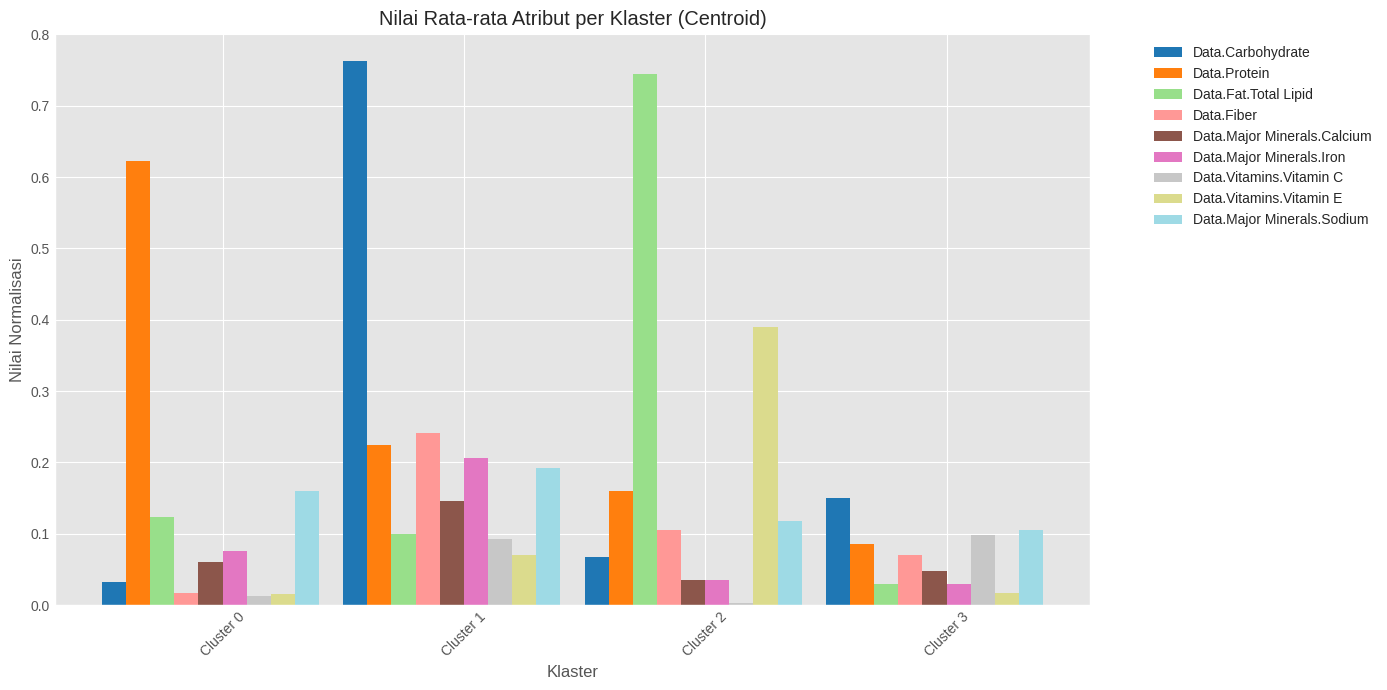

In [ ]:
# -----------------------------------------------------
# 9. VISUALISASI CENTROID DENGAN BAR PLOT
# -----------------------------------------------------

# Buat kanvas figure untuk plot
plt.figure(figsize=(14, 7))

# Hitung jumlah klaster dan siapkan colormap
num_clusters = len(centroid_df)
colors = plt.cm.get_cmap('tab20', len(kolom_fitur))  # Palet warna untuk membedakan tiap fitur
bar_width = 0.9 / len(kolom_fitur)  # Lebar bar agar semua fitur cukup ditampilkan dalam satu grup klaster

# Loop setiap fitur dan tampilkan nilai rata-rata (centroid) dalam bentuk bar untuk masing-masing klaster
for i, col in enumerate(kolom_fitur):
    plt.bar(np.arange(num_clusters) + i * bar_width,  # Posisi bar
            centroid_df[col],                         # Nilai rata-rata fitur per klaster
            width=bar_width,                          # Lebar bar
            label=col,                                # Label fitur (untuk legenda)
            color=colors(i))                          # Warna berdasarkan fitur

# Atur label sumbu x untuk menampilkan nama klaster di tengah kelompok bar
plt.xticks(np.arange(num_clusters) + bar_width * (len(kolom_fitur) / 2),
           [f'Cluster {i}' for i in range(num_clusters)],
           rotation=45)

# Judul dan label sumbu
plt.title('Nilai Rata-rata Atribut per Klaster (Centroid)', fontsize=14, fontweight='bold')
plt.xlabel('Klaster', fontsize=12)
plt.ylabel('Nilai Normalisasi', fontsize=12)

# Letakkan legenda di samping plot agar tidak menumpuk
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Tata letak otomatis agar elemen tidak terpotong
plt.tight_layout()

# Tampilkan visualisasi
plt.show()


<ipython-input-592-c4e7ee599252>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))


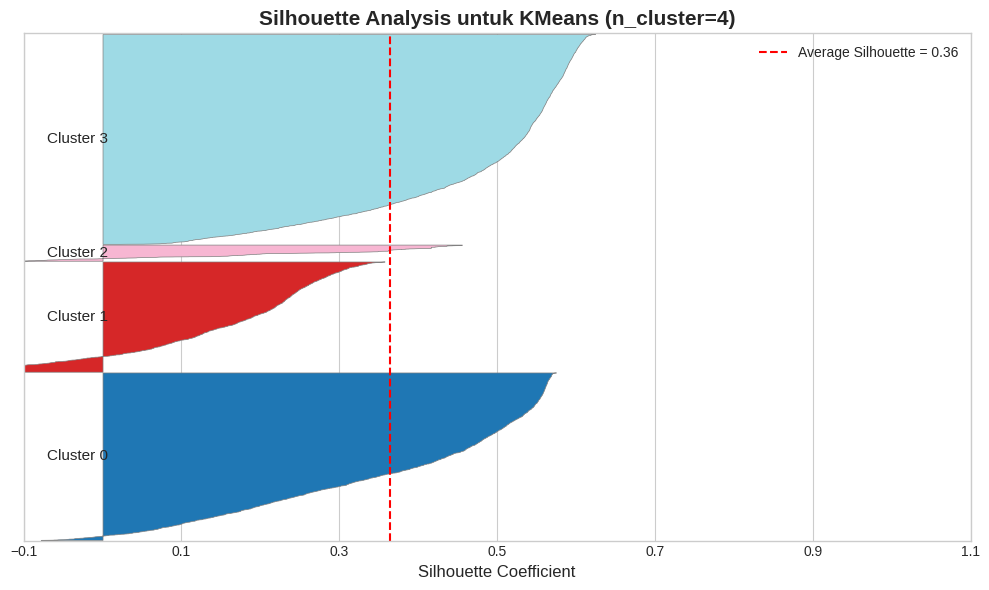

In [ ]:
# -----------------------------------------------------
# 10. HITUNG SILHOUETTE SCORE (menggunakan data hasil seleksi fitur)
# -----------------------------------------------------
# Menghitung skor rata-rata silhouette secara keseluruhan
silhouette_avg = silhouette_score(data_final_threshold, clusters)

# Menghitung nilai silhouette untuk setiap sampel
silhouette_vals = silhouette_samples(data_final_threshold, clusters)

# -----------------------------------------------------
# 11. VISUALISASI SILHOUETTE PLOT
# -----------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

n_clusters = 4  # Jumlah klaster
y_lower = 10    # Posisi awal sumbu y

# Ambil palet warna dari tab20 untuk membedakan klaster
colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))

# Loop untuk menggambar silhouette setiap klaster
for i in range(n_clusters):
    # Ambil nilai silhouette untuk klaster ke-i
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()  # Urutkan untuk area plot yang lebih bersih

    size_cluster_i = cluster_silhouette_vals.shape[0]  # Jumlah sampel dalam klaster
    y_upper = y_lower + size_cluster_i  # Posisi batas atas bar klaster i

    # Gambar area plot untuk nilai silhouette dari klaster ke-i
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i],
                     edgecolor='gray',
                     linewidth=0.5)

    # Tampilkan label klaster di tengah area klaster
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {i}', fontsize=11,
            verticalalignment='center')

    # Update batas bawah untuk klaster selanjutnya
    y_lower = y_upper + 10

# Gambar garis vertikal sebagai rata-rata silhouette keseluruhan
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Tambahkan elemen plot
ax.set_title('Silhouette Analysis untuk KMeans (n_cluster=4)', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Atur skala sumbu
ax.set_xlim([-0.1, 1])  # Silhouette coefficient bernilai antara -1 hingga 1
ax.set_ylim([0, len(data_final_threshold) + (n_clusters + 1) * 10])
ax.set_yticks([])  # Hilangkan ticks y karena tidak informatif
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()

# Tampilkan hasil
plt.show()


In [ ]:
# Setelah clustering
data_bersih['Cluster'] = kmeans.labels_

# Menambahkan kembali kolom 'Description' untuk interpretasi klaster
data_bersih['Description'] = data_deskripsi.loc[data_bersih.index, 'Description']

In [ ]:
# ---------------------------------------------------------
# 11. INTERPRETASI KUALITATIF: TAMPILAN CONTOH MAKANAN PER KLASTER
# ---------------------------------------------------------

# Ambil nama-nama fitur yang digunakan dalam klasterisasi
kolom_fitur = data_final.columns.tolist()

print("\nContoh Makanan per Klaster:")

# Loop melalui masing-masing klaster
for cluster in range(4):
    print(f"\nCluster {cluster}:")

    # Ambil subset data_bersih untuk klaster tersebut
    cluster_data = data_bersih[data_bersih['Cluster'] == cluster]

    # Tampilkan 5 contoh makanan pertama beserta nilai fitur terkait
    print(cluster_data[['Description'] + kolom_fitur].head(5))



Contoh Makanan per Klaster:

Cluster 0:
        Description  Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  \
3       CHEESE,BLUE               2.34         21.40                 28.74   
4      CHEESE,BRICK               2.79         23.24                 29.68   
5       CHEESE,BRIE               0.45         20.75                 27.68   
6  CHEESE,CAMEMBERT               0.46         19.80                 24.26   
7    CHEESE,CARAWAY               3.06         25.18                 29.20   

   Data.Kilocalories  Data.Fiber  Data.Cholesterol  
3             353.00        0.00             75.00  
4             371.00        0.00             94.00  
5             334.00        0.00            100.00  
6             300.00        0.00             72.00  
7             376.00        0.00             93.00  

Cluster 1:
                   Description  Data.Carbohydrate  Data.Protein  \
20              CHEESE,GJETOST              42.65          9.65   
61   CREAM SUBSTITUTE,POWD

In [ ]:
# Asumsi data_final_threshold sudah didefinisikan
# Inisialisasi model KMeans dan klasterisasi (dari kode Anda)
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_final_threshold)  # Menggunakan seluruh data_final_threshold

# Total sampel diambil langsung dari data_final_threshold
n_samples = len(data_final_threshold)

# 1. Distribusi klaster
# Hitung jumlah sampel dalam setiap klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# - Inertia: total jarak dalam klaster (semakin kecil semakin baik)
inertia = kmeans_final.inertia_

# - Silhouette Score: kekompakan dan pemisahan klaster (semakin besar semakin baik)
silhouette_final = silhouette_score(data_final_threshold, clusters_final)

# - Davies-Bouldin Index: rasio penyebaran antar klaster (semakin kecil semakin baik)
db_index_final = davies_bouldin_score(data_final_threshold, clusters_final)
print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Hitung jarak tiap sampel ke centroid klaster terdekat
distances = np.min(kmeans_final.transform(data_final_threshold), axis=1)

# Tetapkan ambang batas outlier pada persentil ke-95 dari jarak
threshold = np.percentile(distances, 95)
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
# Hitung distribusi outlier pada masing-masing klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)

print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 2427 sampel (33.25%)
Klaster 1: 1598 sampel (21.89%)
Klaster 2: 235 sampel (3.22%)
Klaster 3: 3040 sampel (41.64%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 1252.489
Silhouette Score: 0.365
Davies-Bouldin Index: 1.072

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 74 outlier (3.05% dari klaster)
Klaster 1: 222 outlier (13.89% dari klaster)
Klaster 2: 12 outlier (5.11% dari klaster)
Klaster 3: 57 outlier (1.88% dari klaster)


In [ ]:
# Asumsi data_final_threshold dan data_bersih sudah didefinisikan
# Asumsi kmeans_final adalah model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_final_threshold), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_final_threshold)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 22, Nama Item: CHEESE,GRUYERE, Klaster: 0, Jarak ke Centroid: 0.986
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 1.186
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 1.198
Index: 37, Nama Item: CHEESE,ROMANO, Klaster: 0, Jarak ke Centroid: 1.077
Index: 38, Nama Item: CHEESE,ROQUEFORT, Klaster: 0, Jarak ke Centroid: 1.004
Index: 43, Nama Item: CHEESE,PAST PROCESS,SWISS,W/DI NA PO4, Klaster: 0, Jarak ke Centroid: 0.946
Index: 46, Nama Item: CHEESE FD,PAST PROCESS,SWISS, Klaster: 0, Jarak ke Centroid: 0.954
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 0, Jarak ke Centroid: 1.033
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 1.166
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 1.158
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Klaster: 0, Jarak ke Centroid: 1.103
Index: 86, Nama 

## 2. Data Mining Menggunakan K-Means (normalisasi Z-Score)

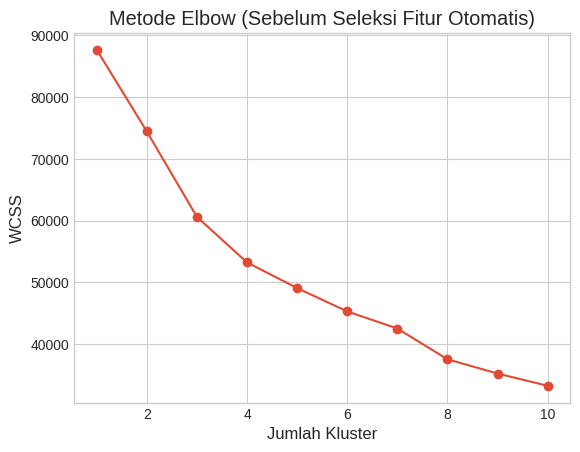

In [ ]:
# ------------------------------
# 1. VALIDASI JUMLAH KLASTER (ELBOW METHOD)
# ------------------------------
# Inisialisasi list untuk menyimpan nilai WCSS (Within-Cluster Sum of Squares)
wcss = []

# Lakukan KMeans untuk jumlah klaster dari 1 sampai 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_normalisasiZScore)  # data sebelum seleksi fitur otomatis
    wcss.append(kmeans.inertia_)       # simpan nilai inertia (WCSS)

# ------------------------------
# 2. PLOT ELBOW METHOD
# ------------------------------
# Visualisasi grafik Elbow untuk menentukan jumlah klaster optimal
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Metode Elbow (Sebelum Seleksi Fitur Otomatis)')
plt.xlabel('Jumlah Klaster')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [ ]:
# Asumsi data_normalisasiZScore sudah didefinisikan
# Inisialisasi model KMeans dengan 4 klaster dan random_state untuk reprodusibilitas
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_normalisasiZScore)  # Menggunakan seluruh data_normalisasiZScore

# Total sampel diambil langsung dari data_normalisasiZScore
n_samples = len(data_normalisasiZScore)

# 1. Distribusi klaster
# Hitung jumlah anggota di setiap klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# Inertia: total jarak kuadrat antar titik ke centroid masing-masing (semakin kecil semakin baik)
inertia = kmeans_final.inertia_

# Silhouette Score: mengukur seberapa mirip titik dalam klaster dibandingkan dengan klaster lain (semakin tinggi semakin baik)
silhouette_final = silhouette_score(data_normalisasiZScore, clusters_final)

# Davies-Bouldin Index: rasio kompak dan pemisahan antar klaster (semakin kecil semakin baik)
db_index_final = davies_bouldin_score(data_normalisasiZScore, clusters_final)

print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Hitung jarak terkecil tiap sampel ke centroid klasternya
distances = np.min(kmeans_final.transform(data_normalisasiZScore), axis=1)

# Tentukan ambang batas 95% sebagai threshold outlier
threshold = np.percentile(distances, 95)

# Identifikasi sampel dengan jarak melebihi threshold
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
# Hitung jumlah outlier di setiap klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)

print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)")


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 2479 sampel (33.96%)
Klaster 1: 3035 sampel (41.58%)
Klaster 2: 280 sampel (3.84%)
Klaster 3: 1506 sampel (20.63%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 53233.309
Silhouette Score: 0.272
Davies-Bouldin Index: 1.397

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 63 outlier (2.54% dari klaster)
Klaster 1: 45 outlier (1.48% dari klaster)
Klaster 2: 45 outlier (16.07% dari klaster)
Klaster 3: 212 outlier (14.08% dari klaster)


In [ ]:
# Asumsi data_normalisasiZScore dan data_bersih sudah didefinisikan
# Asumsi kmeans_final adalah model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_normalisasiZScore), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_normalisasiZScore)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 22, Nama Item: CHEESE,GRUYERE, Klaster: 0, Jarak ke Centroid: 6.708
Index: 27, Nama Item: CHEESE,MOZZARELLA,PART SKIM MILK, Klaster: 0, Jarak ke Centroid: 5.466
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 7.454
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 7.474
Index: 34, Nama Item: CHEESE,PROVOLONE, Klaster: 0, Jarak ke Centroid: 5.541
Index: 37, Nama Item: CHEESE,ROMANO, Klaster: 0, Jarak ke Centroid: 7.010
Index: 38, Nama Item: CHEESE,ROQUEFORT, Klaster: 0, Jarak ke Centroid: 6.112
Index: 39, Nama Item: CHEESE,SWISS, Klaster: 0, Jarak ke Centroid: 5.672
Index: 43, Nama Item: CHEESE,PAST PROCESS,SWISS,W/DI NA PO4, Klaster: 0, Jarak ke Centroid: 6.063
Index: 46, Nama Item: CHEESE FD,PAST PROCESS,SWISS, Klaster: 0, Jarak ke Centroid: 5.966
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 3, Jarak ke Centroid: 6.830
Index: 83, Nama Item: MILK,DRY,NONFA

### Feature Selection menggunakan Silhouette dan DBI

In [ ]:
# ------------------------------
# 3. AUTOMATED FEATURE SELECTION
# ------------------------------
# Fungsi untuk mengevaluasi kontribusi setiap fitur terhadap kualitas klasterisasi
def evaluate_features(data, n_clusters=4):
    # Hitung skor baseline dengan seluruh fitur
    baseline_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    baseline_labels = baseline_kmeans.labels_
    baseline_sil = silhouette_score(data, baseline_labels)
    baseline_db = davies_bouldin_score(data, baseline_labels)

    print(f"Baseline (Semua fitur) -> Silhouette: {baseline_sil:.3f}, Davies-Bouldin: {baseline_db:.3f}")

    result = []

    # Uji setiap fitur dengan cara menghapusnya satu per satu
    for fitur in data.columns:
        subset = data.drop(columns=[fitur])  # Buat subset tanpa fitur saat ini
        labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(subset)

        # Hitung metrik klasterisasi untuk subset
        sil = silhouette_score(subset, labels)
        db = davies_bouldin_score(subset, labels)

        # Simpan perubahan dibanding baseline
        result.append({
            'fitur_dihapus': fitur,
            'silhouette': sil,
            'davies_bouldin': db,
            'delta_silhouette': sil - baseline_sil,
            'delta_db': db - baseline_db
        })

    # Return dataframe hasil evaluasi, diurutkan berdasarkan peningkatan silhouette
    return pd.DataFrame(result).sort_values(by='delta_silhouette', ascending=False)

# Jalankan evaluasi otomatis pada data yang sudah dinormalisasi
hasil_evaluasi = evaluate_features(data_normalisasiZScore)

# Pilih fitur yang jika dihapus justru memperbaiki hasil klasterisasi:
# - Silhouette bertambah
# - Davies-Bouldin menurun
fitur_dihapus_otomatis = hasil_evaluasi[
    (hasil_evaluasi['delta_silhouette'] > 0) &
    (hasil_evaluasi['delta_db'] < 0)
]['fitur_dihapus'].tolist()

# Buat dataset akhir hanya dengan fitur terbaik (tidak dihapus)
fitur_final = [f for f in data_normalisasiZScore.columns if f not in fitur_dihapus_otomatis]
data_final = data_normalisasiZScore[fitur_final]

# Tampilkan hasil akhir
print(f"\nFitur yang dihapus otomatis: {fitur_dihapus_otomatis}")
print(f"Jumlah fitur tersisa: {len(fitur_final)}")

Baseline (Fitur pilihan) -> Silhouette: 0.272, Davies-Bouldin: 1.397

Fitur yang dihapus otomatis: ['Data.Major Minerals.Sodium', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin E']
Jumlah fitur tersisa: 8


In [ ]:
# -----------------------------------------------
# 4. TERAPKAN K-MEANS DENGAN k=4 (FITUR TERPILIH)
# -----------------------------------------------
# Terapkan algoritma KMeans pada data yang sudah melalui proses seleksi fitur
# Menggunakan parameter default umum: k=4, inisialisasi 'k-means++', iterasi maksimal 300
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=42)
clusters = kmeans.fit_predict(data_final)  # data_final = dataset dengan fitur hasil seleksi otomatis

# -----------------------------------------------
# 5. TAMBAHKAN LABEL KLASTER KE DATASET BERSIH
# -----------------------------------------------
# Tambahkan hasil label klaster ke dalam data mentah (data_bersih) sebagai kolom baru
data_bersih['Cluster'] = clusters

# -----------------------------------------------
# 6. SIMPAN DATASET DENGAN LABEL KLASTER
# -----------------------------------------------
# Simpan data akhir (dengan label klaster) ke file CSV untuk analisis lanjutan atau visualisasi
data_bersih.to_csv('makanan_clustered.csv', index=False)
print("Dataset dengan label klaster disimpan sebagai 'makanan_clusteredZScore.csv'")

Dataset dengan label klaster disimpan sebagai 'makanan_clusteredZScore.csv'


In [ ]:
# -----------------------------------------------
# 7. HITUNG JUMLAH DATA PER KLASTER
# -----------------------------------------------

# Menghitung jumlah sampel dalam setiap klaster
cluster_counts = data_bersih['Cluster'].value_counts().sort_index()

# Menampilkan hasil
print("\nJumlah Data per Klaster:")
print(cluster_counts)


Jumlah Data per Klaster:
Cluster
0    1557
1    3072
2    2385
3     286
Name: count, dtype: int64


In [ ]:
# -----------------------------------------------
# 8. ANALISIS CENTROID
# -----------------------------------------------

# Ambil nama-nama fitur dari data_final (hasil dari proses seleksi fitur otomatis)
kolom_fitur = data_final.columns

# Jalankan kembali model KMeans pada data_final untuk memastikan hasil konsisten
# Gunakan parameter yang sama agar hasil replikasi dapat dipercaya
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(data_final)

# Tambahkan label klaster terbaru ke dalam data_bersih
# Pastikan data_bersih masih sinkron dengan data_final (indeks tidak berubah)
data_bersih['Cluster'] = clusters

# Ambil koordinat centroid untuk masing-masing klaster
# Centroid adalah rata-rata nilai setiap fitur dalam klaster tersebut
centroids = kmeans.cluster_centers_

# Ubah centroid menjadi DataFrame agar mudah dibaca dan dianalisis
centroid_df = pd.DataFrame(centroids, columns=kolom_fitur)

# Tampilkan nilai rata-rata fitur (centroid) untuk setiap klaster
print("\nNilai Centroid untuk Setiap Klaster:")
print(centroid_df)



Nilai Centroid untuk Setiap Klaster:
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Kilocalories  \
0              -0.30         -0.75                 -0.49              -0.78   
1               1.76         -0.44                  0.08               1.09   
2               1.29          0.35                  0.36               1.05   
3              -0.68          1.00                  0.47               0.23   

   Data.Fiber  Data.Sugar Total  Data.Vitamins.Vitamin C  Data.Cholesterol  
0       -0.11             -0.20                     0.18             -0.51  
1        0.17              1.52                     0.16             -0.48  
2        2.97             -0.00                     0.27             -0.58  
3       -0.50             -0.44                    -0.33              0.92  


<ipython-input-604-fa0b7c484a28>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(kolom_fitur))


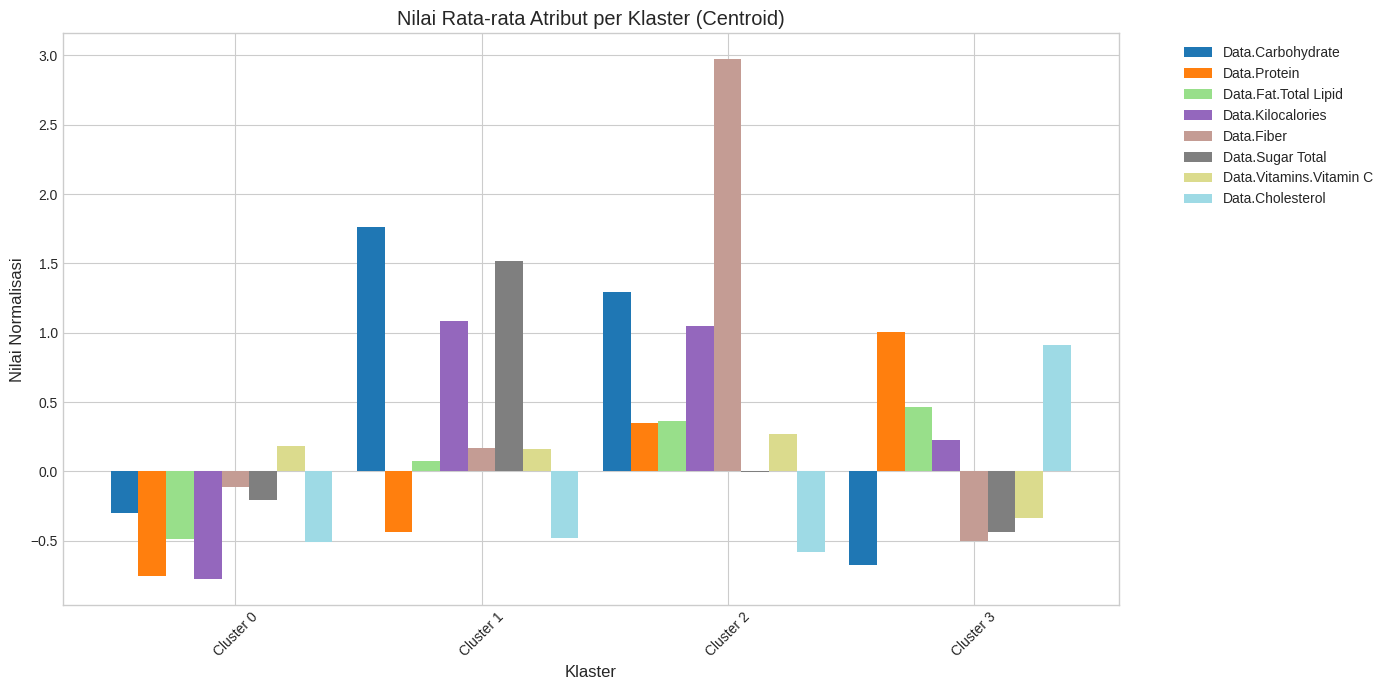

In [ ]:
# -----------------------------------------------
# 9. VISUALISASI CENTROID DENGAN BAR PLOT
# -----------------------------------------------

# Inisialisasi ukuran figure
plt.figure(figsize=(14, 7))

# Jumlah klaster yang ada
num_clusters = len(centroid_df)

# Ambil skema warna dari matplotlib dengan jumlah warna sebanyak fitur
colors = plt.cm.get_cmap('tab20', len(kolom_fitur))

# Lebar setiap batang dalam bar plot disesuaikan agar tidak saling tumpang tindih
bar_width = 0.9 / len(kolom_fitur)

# Buat bar plot untuk setiap fitur
for i, col in enumerate(kolom_fitur):
    # Setiap fitur digeser sedikit agar sejajar dengan klaster
    plt.bar(np.arange(num_clusters) + i * bar_width,
            centroid_df[col],
            width=bar_width,
            label=col,
            color=colors(i))

# Atur posisi label sumbu X di tengah kumpulan bar setiap klaster
plt.xticks(np.arange(num_clusters) + bar_width * (len(kolom_fitur) / 2),
           [f'Cluster {i}' for i in range(num_clusters)],
           rotation=45)

# Tambahkan judul dan label sumbu
plt.title('Nilai Rata-rata Atribut per Klaster (Centroid)')
plt.xlabel('Klaster')
plt.ylabel('Nilai Normalisasi')

# Tampilkan legenda di luar area plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Pastikan layout tidak terpotong
plt.tight_layout()

# Tampilkan plot
plt.show()


<ipython-input-605-5f231ac3fb6c>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))


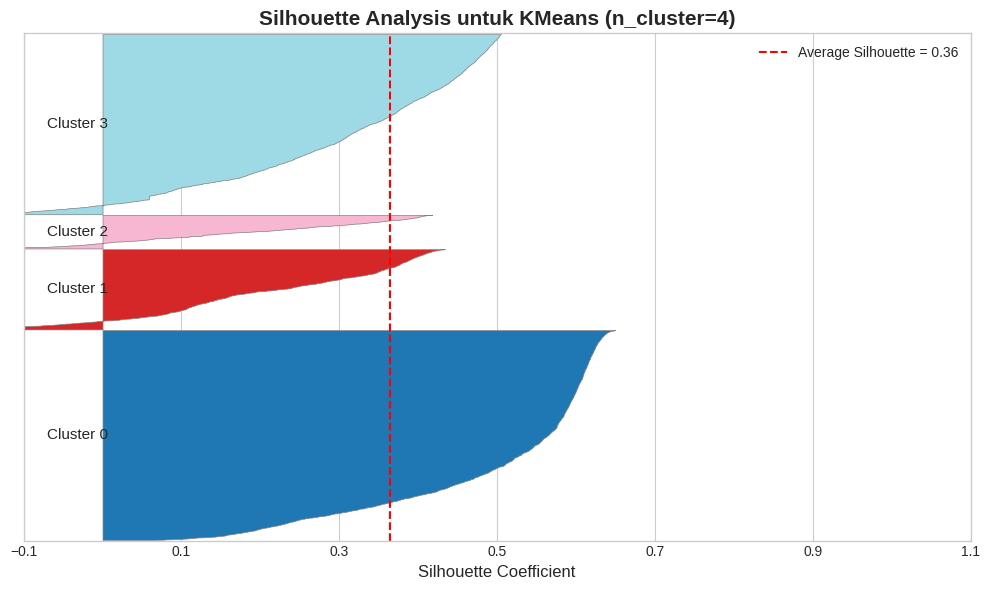

In [ ]:
# -----------------------------------------------
# 10. HITUNG SILHOUETTE SCORE (gunakan data_final)
# -----------------------------------------------

# Hitung nilai rata-rata silhouette untuk keseluruhan klaster
silhouette_avg = silhouette_score(data_final, clusters)

# Hitung nilai silhouette untuk masing-masing sampel
silhouette_vals = silhouette_samples(data_final, clusters)

# -----------------------------------------------
# 11. VISUALISASI SILHOUETTE PLOT
# -----------------------------------------------

# Gunakan style grid putih
plt.style.use('seaborn-v0_8-whitegrid')

# Siapkan canvas plot
fig, ax = plt.subplots(figsize=(10, 6))

# Jumlah klaster
n_clusters = 4
y_lower = 10  # posisi awal pada sumbu Y

# Ambil warna untuk tiap klaster
colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))

# Loop tiap klaster untuk plot
for i in range(n_clusters):
    # Ambil nilai silhouette untuk klaster i
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()  # urutkan untuk keindahan grafik

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Plot area untuk klaster i
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i],
                     edgecolor='gray',
                     linewidth=0.5)

    # Tambahkan label nama klaster
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {i}', fontsize=11,
            verticalalignment='center')

    y_lower = y_upper + 10  # naikkan posisi Y untuk klaster berikutnya

# Tambahkan garis vertikal rata-rata silhouette
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Tambahkan judul dan label sumbu
ax.set_title('Silhouette Analysis untuk KMeans (n_cluster=4)', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Atur batas sumbu dan tampilan
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final) + (n_clusters + 1) * 10])
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Tampilkan legenda
ax.legend(loc='upper right', fontsize=10)

# Rapikan tata letak plot
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------
# 12. EVALUASI ULANG SETELAH FITUR DIHAPUS
# -----------------------------------------------
# Inisialisasi model KMeans dengan jumlah klaster yang sama
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_final)

# Hitung metrik evaluasi pada data_final
silhouette_final = silhouette_score(data_final, clusters_final)
db_index_final = davies_bouldin_score(data_final, clusters_final)

# Tampilkan hasil evaluasi
print(f"\nEvaluasi ulang setelah seleksi fitur otomatis (Z-score normalized):")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")


Evaluasi ulang setelah seleksi fitur otomatis (Z-score normalized):
Silhouette Score: 0.364
Davies-Bouldin Index: 1.262


In [ ]:
# Setelah clustering
data_bersih['Cluster'] = kmeans.labels_

# Menambahkan kembali kolom 'Description' untuk interpretasi klaster
data_bersih['Description'] = data_deskripsi.loc[data_bersih.index, 'Description']

In [ ]:
# -----------------------------------------------
# 13. INTERPRETASI KUALITATIF: TAMPILAN CONTOH MAKANAN PER KLASTER
# -----------------------------------------------

# Simpan nama-nama kolom fitur hasil seleksi otomatis (setelah normalisasi Z-score)
kolom_fitur = data_final.columns.tolist()

# Cetak contoh makanan dari tiap klaster
print("\nContoh Makanan per Klaster:")

# Iterasi untuk setiap klaster (0 sampai 3)
for cluster in range(4):
    print(f"\nCluster {cluster}:")

    # Ambil subset data makanan yang termasuk dalam klaster tertentu
    cluster_data = data_bersih[data_bersih['Cluster'] == cluster]

    # Tampilkan 5 contoh makanan dari klaster, dengan deskripsi dan nilai fitur terpilih
    print(cluster_data[['Description'] + kolom_fitur].head(5))


Contoh Makanan per Klaster:

Cluster 0:
                                         Description  Data.Carbohydrate  \
11               CHEESE,COTTAGE,CRMD,LRG OR SML CURD               3.38   
12                       CHEESE,COTTAGE,CRMD,W/FRUIT               4.61   
13  CHEESE,COTTAGE,NONFAT,UNCRMD,DRY,LRG OR SML CURD               6.66   
14                  CHEESE,COTTAGE,LOWFAT,2% MILKFAT               3.66   
15                  CHEESE,COTTAGE,LOWFAT,1% MILKFAT               2.72   

    Data.Protein  Data.Fat.Total Lipid  Data.Kilocalories  Data.Fiber  \
11         11.12                  4.30              98.00        0.00   
12         10.69                  3.85              97.00        0.20   
13         10.34                  0.29              72.00        0.00   
14         11.83                  2.45              86.00        0.00   
15         12.39                  1.02              72.00        0.00   

    Data.Sugar Total  Data.Vitamins.Vitamin C  Data.Cholesterol  
11 

In [ ]:
# Asumsi data_final sudah didefinisikan
# Inisialisasi model KMeans dan klasterisasi (dari kode Anda)
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_final)  # Menggunakan seluruh data_final

# Total sampel diambil langsung dari data_final
n_samples = len(data_final)

# 1. Distribusi klaster
# Hitung jumlah sampel dalam tiap klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# Hitung evaluasi performa klasterisasi:
inertia = kmeans_final.inertia_  # WCSS (Within-Cluster Sum of Squares)
silhouette_final = silhouette_score(data_final, clusters_final)  # Silhouette Score
db_index_final = davies_bouldin_score(data_final, clusters_final)  # Davies-Bouldin Index

# Tampilkan metrik evaluasi
print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Hitung jarak minimum setiap titik ke centroid klaster
distances = np.min(kmeans_final.transform(data_final), axis=1)

# Gunakan threshold persentil ke-95 sebagai batas deteksi outlier
threshold = np.percentile(distances, 95)
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

# Tampilkan jumlah dan persentase outlier
print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
# Hitung jumlah outlier dalam masing-masing klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)

# Tampilkan distribusi outlier per klaster
print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)")


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 3040 sampel (41.64%)
Klaster 1: 1163 sampel (15.93%)
Klaster 2: 486 sampel (6.66%)
Klaster 3: 2611 sampel (35.77%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 30440.586
Silhouette Score: 0.364
Davies-Bouldin Index: 1.262

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 56 outlier (1.84% dari klaster)
Klaster 1: 47 outlier (4.04% dari klaster)
Klaster 2: 41 outlier (8.44% dari klaster)
Klaster 3: 221 outlier (8.46% dari klaster)


In [ ]:
# Asumsi data_final dan data_bersih sudah didefinisikan
# Asumsi kmeans_final adalah model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_final), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_final)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 0, Nama Item: BUTTER,WITH SALT, Klaster: 3, Jarak ke Centroid: 5.915
Index: 1, Nama Item: BUTTER,WHIPPED,WITH SALT, Klaster: 3, Jarak ke Centroid: 5.944
Index: 2, Nama Item: BUTTER OIL,ANHYDROUS, Klaster: 3, Jarak ke Centroid: 7.550
Index: 111, Nama Item: EGG,WHOLE,RAW,FRESH, Klaster: 3, Jarak ke Centroid: 5.113
Index: 113, Nama Item: EGG,YOLK,RAW,FRSH, Klaster: 3, Jarak ke Centroid: 5.055
Index: 114, Nama Item: EGG,YOLK,RAW,FROZEN, Klaster: 3, Jarak ke Centroid: 5.047
Index: 115, Nama Item: EGG,YOLK,RAW,FRZ,SUGARED, Klaster: 3, Jarak ke Centroid: 5.059
Index: 116, Nama Item: EGG,WHL,CKD,FRIED, Klaster: 3, Jarak ke Centroid: 5.044
Index: 117, Nama Item: EGG,WHL,CKD,HARD-BOILED, Klaster: 3, Jarak ke Centroid: 5.100
Index: 118, Nama Item: EGG,WHOLE,COOKED,OMELET, Klaster: 3, Jarak ke Centroid: 5.110
Index: 119, Nama Item: EGG,WHL,CKD,POACHED, Klaster: 3, Jarak ke Centroid: 5.114
Index: 120, Nama Item: EGG,WHL,CKD

### Feature Selection menggunakan Threshold Correlation

In [ ]:
# ------------------------------
# 3. FEATURE SELECTION: CORRELATION FILTERING DENGAN PENCARIAN THRESHOLD TERBAIK
# ------------------------------
def correlation_filtering_auto(data, thresholds=None, n_clusters=4):
    # Daftar threshold korelasi yang akan diuji
    if thresholds is None:
        thresholds = np.arange(0.5, 0.96, 0.05)

    hasil_evaluasi = []

    print("Mengevaluasi berbagai threshold korelasi...\n")
    for threshold in thresholds:
        # Hitung matriks korelasi absolut antar fitur
        corr_matrix = data.corr().abs()

        # Ambil bagian atas dari matriks korelasi (karena simetris)
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Identifikasi fitur yang korelasinya melebihi threshold
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

        # Hapus fitur yang terlalu berkorelasi
        data_filtered = data.drop(columns=to_drop)

        # Lakukan klasterisasi KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data_filtered)

        # Hitung metrik evaluasi klaster
        sil = silhouette_score(data_filtered, labels)
        db = davies_bouldin_score(data_filtered, labels)

        # Simpan hasil evaluasi
        hasil_evaluasi.append({
            'threshold': threshold,
            'n_features': data_filtered.shape[1],
            'n_dropped': len(to_drop),
            'silhouette': sil,
            'davies_bouldin': db
        })

        print(f"Threshold: {threshold:.2f} | Dropped: {len(to_drop)} | S: {sil:.3f} | DBI: {db:.3f}")

    # Konversi hasil ke DataFrame untuk pemeringkatan
    df_eval = pd.DataFrame(hasil_evaluasi)

    # Hitung peringkat: kombinasi Silhouette tinggi dan DBI rendah
    df_eval['sil_rank'] = df_eval['silhouette'].rank(ascending=False)
    df_eval['dbi_rank'] = df_eval['davies_bouldin'].rank(ascending=True)
    df_eval['total_rank'] = df_eval['sil_rank'] + df_eval['dbi_rank']

    # Ambil threshold dengan total ranking terbaik
    best_threshold = df_eval.sort_values(by='total_rank').iloc[0]['threshold']

    print(f"\nThreshold terbaik berdasarkan gabungan metrik: {best_threshold:.2f}")

    # Terapkan kembali threshold terbaik pada data
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
    data_final = data.drop(columns=to_drop)

    # Evaluasi akhir menggunakan threshold terbaik
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42)
    labels_final = kmeans_final.fit_predict(data_final)
    sil_final = silhouette_score(data_final, labels_final)
    db_final = davies_bouldin_score(data_final, labels_final)

    print(f"\nEvaluasi Akhir (Threshold = {best_threshold:.2f}):")
    print(f"Jumlah fitur tersisa: {data_final.shape[1]}")
    print(f"Silhouette Score: {sil_final:.3f}")
    print(f"Davies-Bouldin Index: {db_final:.3f}")

    return data_final, df_eval

# Panggil fungsi untuk menjalankan seleksi fitur otomatis berbasis korelasi
data_final_threshold, evaluasi_thresholds = correlation_filtering_auto(data_normalisasiZScore)

Mengevaluasi berbagai threshold korelasi...

Threshold: 0.50 | Dropped: 3 | S: 0.248 | DBI: 1.453
Threshold: 0.55 | Dropped: 3 | S: 0.248 | DBI: 1.453
Threshold: 0.60 | Dropped: 2 | S: 0.296 | DBI: 1.366
Threshold: 0.65 | Dropped: 1 | S: 0.257 | DBI: 1.723
Threshold: 0.70 | Dropped: 1 | S: 0.257 | DBI: 1.723
Threshold: 0.75 | Dropped: 1 | S: 0.257 | DBI: 1.723
Threshold: 0.80 | Dropped: 0 | S: 0.272 | DBI: 1.397
Threshold: 0.85 | Dropped: 0 | S: 0.272 | DBI: 1.397
Threshold: 0.90 | Dropped: 0 | S: 0.272 | DBI: 1.397
Threshold: 0.95 | Dropped: 0 | S: 0.272 | DBI: 1.397

Threshold terbaik berdasarkan gabungan metrik: 0.60

Evaluasi Akhir (Threshold = 0.60):
Jumlah fitur tersisa: 10
Silhouette Score: 0.296
Davies-Bouldin Index: 1.366


In [ ]:
# -----------------------------------------------
# 4. TERAPKAN K-MEANS DENGAN k=4 (FITUR TERPILIH)
# -----------------------------------------------
# Terapkan KMeans pada data hasil seleksi fitur
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=42)
# Lakukan klasterisasi pada data hasil seleksi fitur
clusters = kmeans.fit_predict(data_final_threshold)

# -----------------------------------------------
# 5. TAMBAHKAN LABEL KLASTER KE DATASET BERSIH
# -----------------------------------------------
# Tambahkan hasil klasterisasi ke dataset asli (tanpa fitur yang dibuang)
data_bersih['Cluster'] = clusters

# -----------------------------------------------
# 6. SIMPAN DATASET DENGAN LABEL KLASTER
# -----------------------------------------------
# Simpan dataset yang telah diberi label klaster ke file CSV
data_bersih.to_csv('makanan_clustered.csv', index=False)
print("Dataset dengan label klaster disimpan sebagai 'makanan_clustered_threshold_ZScore.csv'")

Dataset dengan label klaster disimpan sebagai 'makanan_clustered_threshold_ZScore.csv'


In [ ]:
# -----------------------------------------------
# 7. HITUNG JUMLAH DATA PER KLASTER
# -----------------------------------------------

# Menghitung jumlah sampel dalam setiap klaster
cluster_counts = data_bersih['Cluster'].value_counts().sort_index()

# Menampilkan hasil
print("\nJumlah Data per Klaster:")
print(cluster_counts)


Jumlah Data per Klaster:
Cluster
0    2370
1     548
2     253
3    4129
Name: count, dtype: int64


In [ ]:
# -----------------------------------------------
# 8. ANALISIS CENTROID
# -----------------------------------------------

# Ambil nama kolom dari data_final_threshold (hasil feature selection)
kolom_fitur = data_final_threshold.columns

# Jalankan kembali KMeans pada data_final_threshold (pastikan modelnya sesuai)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(data_final_threshold)

# Simpan ke data_bersih
data_bersih['Cluster'] = clusters

# Ambil nilai centroid
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=kolom_fitur)

print("\nNilai Centroid untuk Setiap Klaster:")
print(centroid_df)


Nilai Centroid untuk Setiap Klaster:
   Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Fiber  \
0              -0.71          1.17                  0.17       -0.50   
1               1.71          0.18                 -0.16        2.10   
2              -0.44         -0.45                  3.94        0.21   
3               0.21         -0.67                 -0.32       -0.00   

   Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
0                        -0.13                     -0.09   
1                         1.71                      2.46   
2                        -0.21                     -0.28   
3                        -0.14                     -0.26   

   Data.Vitamins.Vitamin C  Data.Vitamins.Vitamin E  \
0                    -0.33                    -0.19   
1                     0.91                     0.77   
2                    -0.34                     2.80   
3                     0.09                    -0.16   

   Data.Major Minerals.S

<ipython-input-615-fa0b7c484a28>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(kolom_fitur))


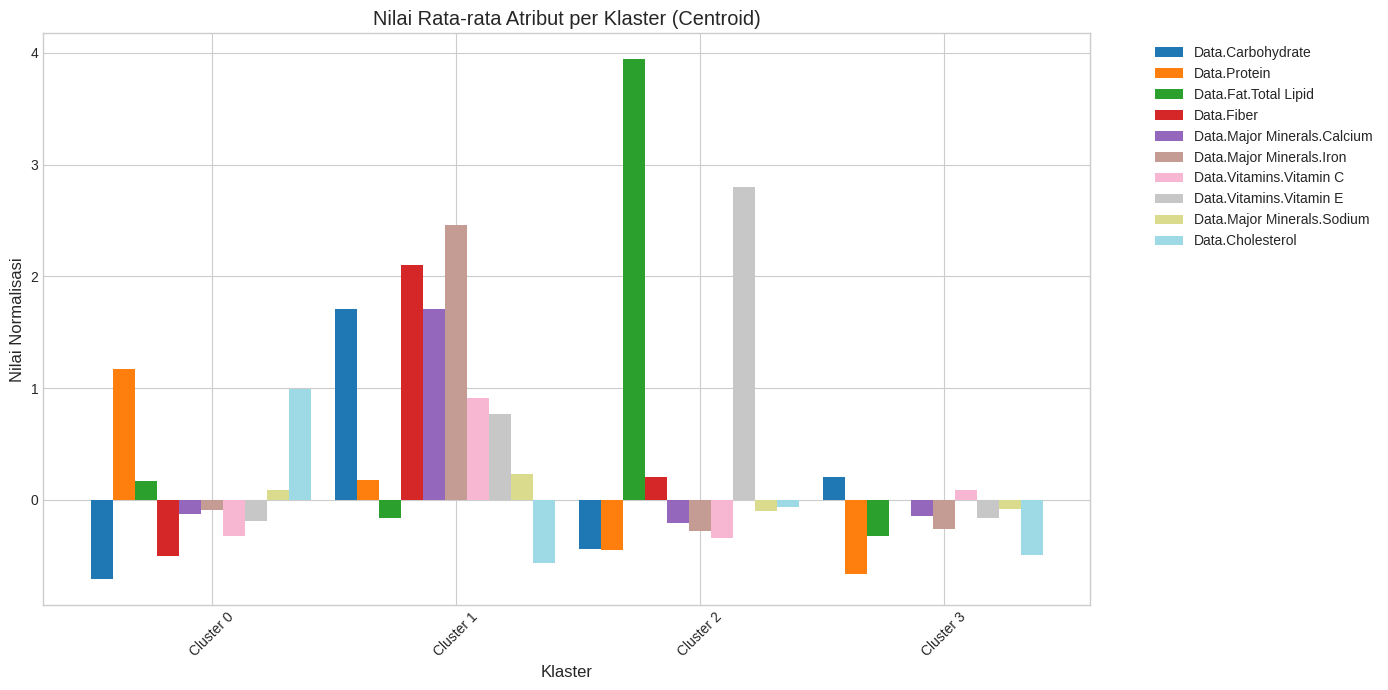

In [ ]:
# -----------------------------------------------
# 9. VISUALISASI CENTROID DENGAN BAR PLOT
# -----------------------------------------------

# Visualisasi nilai rata-rata (centroid) dari tiap fitur pada setiap klaster
# untuk membantu interpretasi pola klaster

plt.figure(figsize=(14, 7))  # Ukuran plot

num_clusters = len(centroid_df)  # Jumlah klaster
colors = plt.cm.get_cmap('tab20', len(kolom_fitur))  # Skema warna
bar_width = 0.9 / len(kolom_fitur)  # Lebar bar per fitur

# Loop setiap fitur untuk digambar
for i, col in enumerate(kolom_fitur):
    plt.bar(np.arange(num_clusters) + i * bar_width,
            centroid_df[col],
            width=bar_width,
            label=col,
            color=colors(i))  # Warna berdasarkan indeks fitur

# Atur label pada sumbu X
plt.xticks(np.arange(num_clusters) + bar_width * (len(kolom_fitur) / 2),
           [f'Cluster {i}' for i in range(num_clusters)],
           rotation=45)

# Judul dan label sumbu
plt.title('Nilai Rata-rata Atribut per Klaster (Centroid)')
plt.xlabel('Klaster')
plt.ylabel('Nilai Normalisasi')

# Tampilkan legenda di luar plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-616-c4e7ee599252>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))


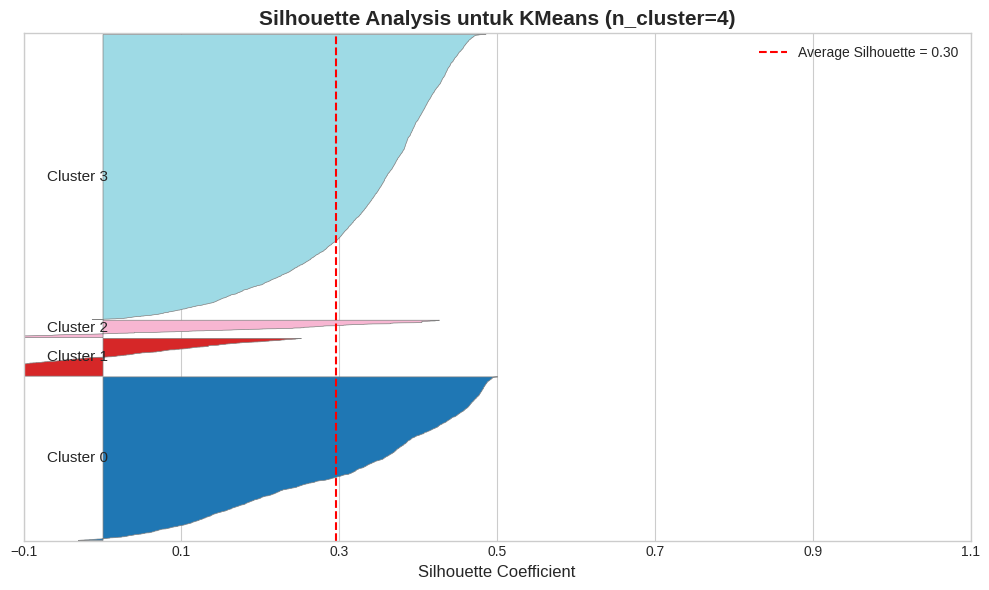

In [ ]:
# -----------------------------------------------
# 10. HITUNG SILHOUETTE SCORE (gunakan data_final_threshold)
# -----------------------------------------------
silhouette_avg = silhouette_score(data_final_threshold, clusters)  # Rata-rata silhouette
silhouette_vals = silhouette_samples(data_final_threshold, clusters)  # Silhouette per sampel

# ---------------------------------------------------------------
# 11. VISUALISASI SILHOUETTE PLOT
# ---------------------------------------------------------------
# Menampilkan silhouette plot untuk memvisualisasikan kepadatan dan pemisahan antar klaster

plt.style.use('seaborn-v0_8-whitegrid')  # Gaya visual
fig, ax = plt.subplots(figsize=(10, 6))

n_clusters = 4
y_lower = 10  # Inisialisasi posisi y untuk setiap klaster

colors = cm.get_cmap('tab20')(np.linspace(0, 1, n_clusters))  # Warna untuk tiap klaster

# Loop untuk visualisasi silhouette tiap klaster
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Gambar area silhouette untuk klaster ke-i
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i],
                     edgecolor='gray',
                     linewidth=0.5)

    # Teks klaster
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {i}', fontsize=11,
            verticalalignment='center')

    y_lower = y_upper + 10  # Spasi antar klaster

# Garis vertikal untuk rata-rata silhouette
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Pengaturan visual
ax.set_title('Silhouette Analysis untuk KMeans (n_cluster=4)', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final_threshold) + (n_clusters + 1) * 10])
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Setelah clustering
data_bersih['Cluster'] = kmeans.labels_

# Menambahkan kembali kolom 'Description' untuk interpretasi klaster
data_bersih['Description'] = data_deskripsi.loc[data_bersih.index, 'Description']

In [ ]:
# -------------------------------------------------------------------
# 12. INTERPRETASI KUALITATIF: TAMPILAN CONTOH MAKANAN PER KLASTER
# -------------------------------------------------------------------
# Menampilkan 5 contoh makanan dari masing-masing klaster untuk interpretasi
# Tujuan: Membantu memahami karakteristik umum tiap klaster berdasarkan deskripsi

kolom_fitur = data_final_threshold.columns.tolist()  # Ambil nama fitur terpilih

print("\nContoh Makanan per Klaster:")
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    cluster_data = data_bersih[data_bersih['Cluster'] == cluster]  # Filter data berdasarkan klaster
    # Tampilkan 5 baris teratas dengan kolom deskripsi dan fitur terpilih
    print(cluster_data[['Description'] + kolom_fitur].head(5))


Contoh Makanan per Klaster:

Cluster 0:
        Description  Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  \
3       CHEESE,BLUE               2.34         21.40                 28.74   
4      CHEESE,BRICK               2.79         23.24                 29.68   
5       CHEESE,BRIE               0.45         20.75                 27.68   
6  CHEESE,CAMEMBERT               0.46         19.80                 24.26   
7    CHEESE,CARAWAY               3.06         25.18                 29.20   

   Data.Fiber  Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
3        0.00                          528                      0.31   
4        0.00                          674                      0.43   
5        0.00                          184                      0.50   
6        0.00                          388                      0.33   
7        0.00                          673                      0.64   

   Data.Vitamins.Vitamin C  Data.Vitamins.Vitamin E  \
3 

In [ ]:
# Asumsi data_final_threshold sudah didefinisikan
# Inisialisasi model KMeans dan klasterisasi (dari kode Anda)
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_final_threshold)  # Menggunakan seluruh data_final_threshold

# Total sampel diambil langsung dari data_final_threshold
n_samples = len(data_final_threshold)

# 1. Distribusi klaster
cluster_counts = np.bincount(clusters_final, minlength=4)
print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
for i, count in enumerate(cluster_counts):
    percentage = (count / n_samples) * 100
    print(f"Klaster {i}: {count} sampel ({percentage:.2f}%)")

# 2. Metrik evaluasi
# Inertia: total variansi dalam klaster (semakin kecil semakin baik)
inertia = kmeans_final.inertia_

# Silhouette Score: konsistensi internal klaster (semakin besar semakin baik)
silhouette_final = silhouette_score(data_final_threshold, clusters_final)

# Davies-Bouldin Index: rasio jarak antar-klaster (semakin kecil semakin baik)
db_index_final = davies_bouldin_score(data_final_threshold, clusters_final)

print(f"\nMetrik Evaluasi Klaster:")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.3f}")
print(f"Silhouette Score: {silhouette_final:.3f}")
print(f"Davies-Bouldin Index: {db_index_final:.3f}")

# 3. Outlier analysis
# Menghitung jarak minimum setiap titik ke centroid terdekat
distances = np.min(kmeans_final.transform(data_final_threshold), axis=1)

# Menentukan ambang batas outlier pada persentil ke-95
threshold = np.percentile(distances, 95)
outliers = np.where(distances > threshold)[0]
outlier_percentage = (len(outliers) / n_samples) * 100

print(f"\nOutlier Analysis:")
print(f"Jumlah outlier: {len(outliers)} sampel")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

# 4. Distribusi outlier per klaster
# Menghitung berapa banyak outlier di tiap klaster
outlier_clusters = clusters_final[outliers]
outlier_counts = np.bincount(outlier_clusters, minlength=4)
print(f"\nDistribusi Outlier per Klaster:")
for i, count in enumerate(outlier_counts):
    percentage = (count / cluster_counts[i]) * 100 if cluster_counts[i] > 0 else 0
    print(f"Klaster {i}: {count} outlier ({percentage:.2f}% dari klaster)")


Distribusi Klaster dengan 7300 sampel:
Klaster 0: 2370 sampel (32.47%)
Klaster 1: 548 sampel (7.51%)
Klaster 2: 253 sampel (3.47%)
Klaster 3: 4129 sampel (56.56%)

Metrik Evaluasi Klaster:
Inertia (Within-Cluster Sum of Squares): 45160.886
Silhouette Score: 0.296
Davies-Bouldin Index: 1.366

Outlier Analysis:
Jumlah outlier: 365 sampel
Persentase outlier: 5.00%

Distribusi Outlier per Klaster:
Klaster 0: 103 outlier (4.35% dari klaster)
Klaster 1: 152 outlier (27.74% dari klaster)
Klaster 2: 45 outlier (17.79% dari klaster)
Klaster 3: 65 outlier (1.57% dari klaster)


In [ ]:
# Asumsi data_final dan data_bersih sudah didefinisikan
# Asumsi kmeans_final adalah model KMeans yang sudah dilatih

# Hitung jarak ke centroid terdekat untuk setiap titik
distances = np.min(kmeans_final.transform(data_final_threshold), axis=1)

# Tentukan threshold untuk outlier (persentil ke-95)
threshold = np.percentile(distances, 95)

# Identifikasi indeks outlier
outliers = np.where(distances > threshold)[0]

# Ambil label klaster dari kmeans_final
clusters_final = kmeans_final.predict(data_final_threshold)

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        cluster = clusters_final[idx]
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        distance = distances[idx]
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 8, Nama Item: CHEESE,CHEDDAR, Klaster: 0, Jarak ke Centroid: 5.211
Index: 17, Nama Item: CHEESE,EDAM, Klaster: 0, Jarak ke Centroid: 5.404
Index: 21, Nama Item: CHEESE,GOUDA, Klaster: 0, Jarak ke Centroid: 5.104
Index: 22, Nama Item: CHEESE,GRUYERE, Klaster: 0, Jarak ke Centroid: 6.615
Index: 24, Nama Item: CHEESE,MONTEREY, Klaster: 0, Jarak ke Centroid: 5.303
Index: 27, Nama Item: CHEESE,MOZZARELLA,PART SKIM MILK, Klaster: 0, Jarak ke Centroid: 5.491
Index: 28, Nama Item: CHEESE,MOZZARELLA,PART SKIM MILK,LO MOIST, Klaster: 0, Jarak ke Centroid: 5.139
Index: 29, Nama Item: CHEESE,MUENSTER, Klaster: 0, Jarak ke Centroid: 5.127
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 7.364
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 7.426
Index: 34, Nama Item: CHEESE,PROVOLONE, Klaster: 0, Jarak ke Centroid: 5.509
Index: 37, Nama Item: CHEESE,ROMANO, Klaster: 0, 

## 3. Data Mining Menggunakan DBSCAN (normalisasi Min-Max Scaling)

Menggunakan dataset yang sudah dinormalisasi (data_normalisasi)...
Ukuran data_normalisasi: (7300, 12)
Kolom fitur: ['Data.Carbohydrate', 'Data.Protein', 'Data.Fat.Total Lipid', 'Data.Kilocalories', 'Data.Fiber', 'Data.Sugar Total', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin C', 'Data.Vitamins.Vitamin E', 'Data.Major Minerals.Sodium', 'Data.Cholesterol']

Menentukan eps menggunakan K-Distance Graph dengan min_samples = 24...


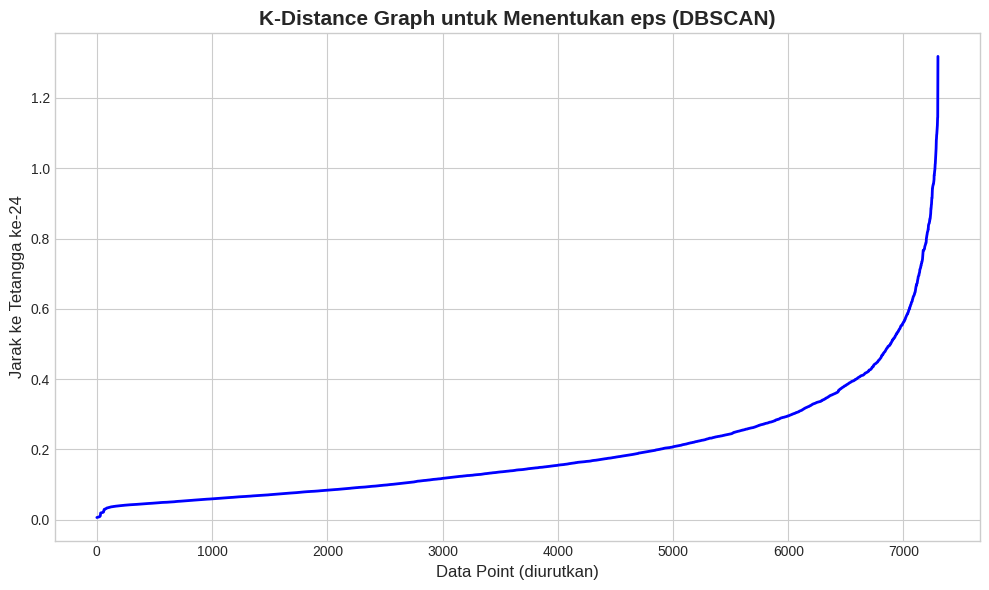


Silakan amati grafik K-Distance di atas.
Temukan titik 'siku' (elbow) pada kurva — itulah nilai eps yang optimal.
Lanjutkan DBSCAN dengan nilai eps tersebut.


In [ ]:
# Menampilkan informasi awal tentang dataset yang digunakan
print("Menggunakan dataset yang sudah dinormalisasi (data_normalisasi)...")
print("Ukuran data_normalisasi:", data_normalisasi.shape)
print("Kolom fitur:", list(data_normalisasi.columns))

# -----------------------------------------------
# 1. MENENTUKAN min_samples UNTUK DBSCAN
# -----------------------------------------------
# aturan umum: min_samples = 2 * jumlah fitur
n_features = data_normalisasi.shape[1]
min_samples = 2 * n_features
print(f"\nMenentukan eps menggunakan K-Distance Graph dengan min_samples = {min_samples}...")

# -----------------------------------------------
# 2. MENGHITUNG JARAK KE TETANGGA KE-min_samples
# -----------------------------------------------
# diperlukan untuk membuat K-Distance Graph
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_normalisasi)
distances, indices = neighbors_fit.kneighbors(data_normalisasi)

# -----------------------------------------------
# 3. MENGURUTKAN JARAK KE TETANGGA TERJAUH
# -----------------------------------------------
# jarak ini akan digunakan untuk menemukan elbow point
k_distances = np.sort(distances[:, -1])  # ambil jarak ke tetangga terjauh

# -----------------------------------------------
# 4. PLOT K-DISTANCE GRAPH UNTUK MENENTUKAN eps
# -----------------------------------------------
# nilai eps optimal berada di titik 'siku' dari kurva
plt.figure(figsize=(10, 6))
plt.plot(k_distances, color='blue', linewidth=2)
plt.title('K-Distance Graph untuk Menentukan eps (DBSCAN)', fontsize=15, fontweight='bold')
plt.xlabel('Data Point (diurutkan)', fontsize=12)
plt.ylabel(f'Jarak ke Tetangga ke-{min_samples}', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Output instruksi
print("\nSilakan amati grafik K-Distance di atas.")
print("Temukan titik 'siku' (elbow) pada kurva — itulah nilai eps yang optimal.")
print("Lanjutkan DBSCAN dengan nilai eps tersebut.")

In [ ]:
# Melakukan klasterisasi menggunakan DBSCAN dan menganalisis distribusi klaster serta outlier
def analisis_dbscan(data, eps=0.42, min_samples=24):
    n_samples = len(data)

    # DBSCAN fit
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)

    # Identifikasi noise dan klaster
    noise_mask = labels == -1
    cluster_labels = labels[~noise_mask]
    unique_clusters = sorted(set(cluster_labels))

    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")

    # Distribusi jumlah sampel di tiap klaster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Outlier Analysis
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels

    # Distribusi outlier berdasarkan klaster terdekat
    # (Menghitung jarak Euclidean ke rata-rata titik di setiap klaster)
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}
    for i in range(n_samples):
        if noise_mask[i]:
            # Cari klaster terdekat dari titik outlier (menggunakan jarak Euclidean ke pusat klaster)
            # Hitung jarak outlier ke setiap pusat klaster
            dists = []
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]
                center = cluster_points.mean(axis=0)
                dist = np.linalg.norm(data.iloc[i] - center)
                dists.append(dist)
            nearest_cluster = unique_clusters[np.argmin(dists)]
            outlier_distribution[nearest_cluster] += 1

    # Tampilkan distribusi outlier berdasarkan klaster terdekat
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels

# Panggil fungsi
labels_dbscan = analisis_dbscan(pd.DataFrame(data_normalisasi), eps=0.42, min_samples=24)


Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 295 sampel (4.04%)
Klaster 0: 6980 sampel (95.62%)
Klaster 1: 25 sampel (0.34%)

Outlier Analysis:
Jumlah outlier: 295 sampel
Persentase outlier: 4.04%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 162 outlier (54.92% dari seluruh outlier)
Klaster 1: 133 outlier (45.08% dari seluruh outlier)


In [ ]:
# Asumsi data_normalisasi dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=0.42, min_samples=24)
labels = model.fit_predict(data_normalisasi)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Cari klaster terdekat dari titik outlier
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_normalisasi[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_normalisasi.iloc[idx] - center)
            dists.append(dist)
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 0, Nama Item: BUTTER,WITH SALT, Klaster: 0, Jarak ke Centroid: 1.138
Index: 1, Nama Item: BUTTER,WHIPPED,WITH SALT, Klaster: 0, Jarak ke Centroid: 1.165
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 1, Jarak ke Centroid: 0.997
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 1, Jarak ke Centroid: 1.143
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 1, Jarak ke Centroid: 1.133
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Klaster: 0, Jarak ke Centroid: 1.209
Index: 86, Nama Item: MILK,BUTTERMILK,DRIED, Klaster: 1, Jarak ke Centroid: 1.116
Index: 101, Nama Item: WHEY,ACID,DRIED, Klaster: 1, Jarak ke Centroid: 1.066
Index: 103, Nama Item: WHEY,SWEET,DRIED, Klaster: 1, Jarak ke Centroid: 1.027
Index: 121, Nama Item: EGG,WHOLE,DRIED, Klaster: 0, Jarak ke Centroid: 1.334
Index: 122, Nama Item: EGG,WHL,DRIED,STABILIZED,GLUCOSE RED, Klaster: 0, Jarak ke Centroid: 1.344
Index: 125, Nama Item

### Feature Selection menggunakan Silhouette dan DBI

In [ ]:
# -------------------------------------------------------------
# 5. FUNGSI: Evaluasi Kinerja DBSCAN Saat Menghapus Satu Fitur
# -------------------------------------------------------------
# Fungsi ini mengevaluasi dampak penghapusan masing-masing fitur terhadap
# kualitas klaster DBSCAN dengan membandingkan perubahan Silhouette Score
# dan Davies-Bouldin Index terhadap baseline (semua fitur).

def evaluate_features(data, eps=0.42, min_samples=24):
    # Baseline dengan semua fitur
    baseline_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    baseline_labels = baseline_dbscan.labels_

    # Hitung metrik baseline jika jumlah klaster > 1
    if len(set(baseline_labels)) > 1:
        baseline_sil = silhouette_score(data, baseline_labels)
        baseline_db = davies_bouldin_score(data, baseline_labels)
    else:
        baseline_sil, baseline_db = -1, float('inf')  # fallback jika DBSCAN gagal membentuk klaster

    print(f"Baseline (Semua fitur) -> Silhouette: {baseline_sil:.3f}, Davies-Bouldin: {baseline_db:.3f}")

    result = []

    # Loop: Evaluasi dengan menghapus satu fitur pada satu waktu
    for fitur in data.columns:
        subset = data.drop(columns=[fitur])
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(subset)

        # Evaluasi jika DBSCAN menghasilkan lebih dari satu klaster
        if len(set(labels)) > 1:
            sil = silhouette_score(subset, labels)
            db = davies_bouldin_score(subset, labels)
        else:
            sil, db = -1, float('inf')  # fallback jika klaster gagal terbentuk

        result.append({
            'fitur_dihapus': fitur,
            'silhouette': sil,
            'davies_bouldin': db,
            'delta_silhouette': sil - baseline_sil,
            'delta_db': db - baseline_db
        })

    # Kembalikan DataFrame yang diurutkan berdasarkan peningkatan silhouette terbaik
    return pd.DataFrame(result).sort_values(by='delta_silhouette', ascending=False)

# -----------------------------------------------
# 6. Jalankan evaluasi otomatis pada data_normalisasi
# -----------------------------------------------
hasil_evaluasi = evaluate_features(pd.DataFrame(data_normalisasi))

# -----------------------------------------------
# 7. Pilih fitur yang jika dihapus meningkatkan Silhouette & menurunkan DB Index
# -----------------------------------------------
# Kriteria: jika penghapusan meningkatkan silhouette dan menurunkan DB Index
fitur_dihapus_otomatis = hasil_evaluasi[
    (hasil_evaluasi['delta_silhouette'] > 0) &
    (hasil_evaluasi['delta_db'] < 0)
]['fitur_dihapus'].tolist()

# -----------------------------------------------
# 8. Simpan data dengan fitur terbaik
# -----------------------------------------------
fitur_final = [f for f in pd.DataFrame(data_normalisasi).columns if f not in fitur_dihapus_otomatis]
data_final = pd.DataFrame(data_normalisasi)[fitur_final]

print(f"\nFitur yang dihapus otomatis: {fitur_dihapus_otomatis}")
print(f"Jumlah fitur tersisa: {len(fitur_final)}")
print(f"Jumlah fitur tersisa: {(fitur_final)}")

Baseline (Semua fitur) -> Silhouette: 0.387, Davies-Bouldin: 1.840

Fitur yang dihapus otomatis: ['Data.Protein', 'Data.Carbohydrate', 'Data.Major Minerals.Sodium', 'Data.Cholesterol', 'Data.Fat.Total Lipid', 'Data.Kilocalories', 'Data.Major Minerals.Iron']
Jumlah fitur tersisa: 5
Jumlah fitur tersisa: ['Data.Fiber', 'Data.Sugar Total', 'Data.Major Minerals.Calcium', 'Data.Vitamins.Vitamin C', 'Data.Vitamins.Vitamin E']


In [ ]:
# -----------------------------------------------
# 9. Menentukan jumlah cluster dari hasil feature selection
# -----------------------------------------------
labels = DBSCAN(eps=0.42, min_samples=24).fit_predict(data_final)
print(f"Jumlah cluster ditemukan: {len(set(labels)) - (1 if -1 in labels else 0)}")

Jumlah cluster ditemukan: 1


<Figure size 1000x600 with 0 Axes>

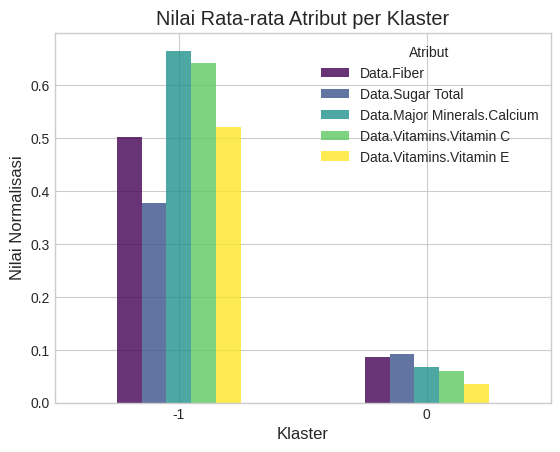

In [ ]:
# -----------------------------------------------
# 10. Visualisasi nilai rata-rata tiap atribut per klaster
# -----------------------------------------------
# Visualisasi ini membantu memahami karakteristik umum dari setiap klaster
# dengan melihat nilai rata-rata fitur normalisasi untuk tiap klaster.

# Salin data final dan tambahkan label klaster yang dihasilkan DBSCAN
df = pd.DataFrame(data_final)
df['Cluster'] = labels  # 'labels' berasal dari hasil DBSCAN sebelumnya

# Hitung nilai rata-rata tiap fitur dalam setiap klaster
df_mean = df.groupby('Cluster').mean()

# Plot barplot rata-rata atribut untuk setiap klaster
plt.figure(figsize=(10, 6))  # Ukuran gambar
df_mean.plot(kind='bar', colormap="viridis", alpha=0.8)  # colormap untuk pewarnaan, alpha untuk transparansi

# Label dan judul grafik
plt.xlabel("Klaster")
plt.ylabel("Nilai Normalisasi")
plt.title("Nilai Rata-rata Atribut per Klaster")

# Rotasi label x agar horizontal
plt.xticks(rotation=0)

# Tambahkan legenda untuk tiap atribut
plt.legend(title="Atribut")

# Tampilkan plot
plt.show()

<ipython-input-627-6dddd02d5da4>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))


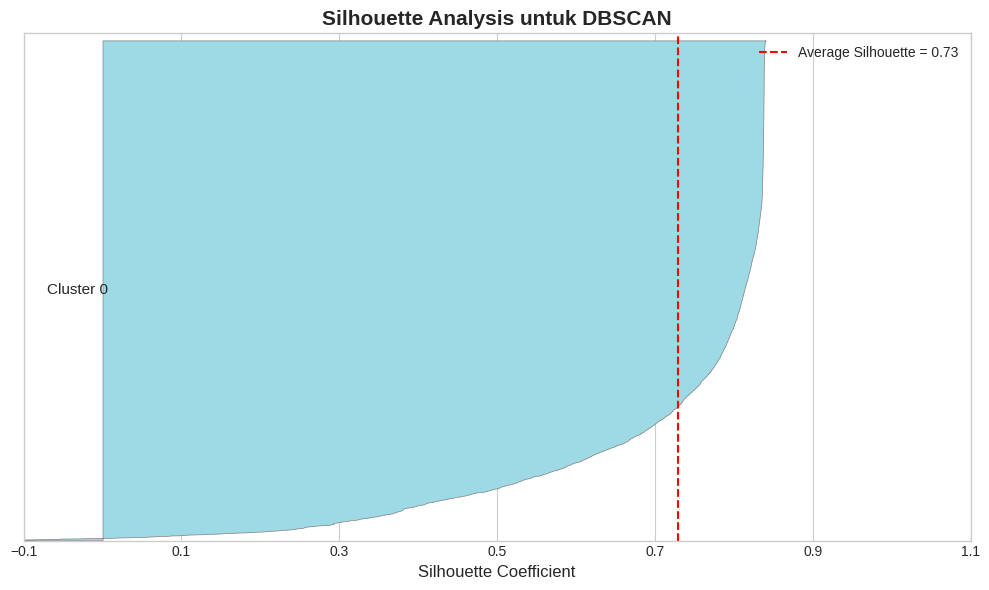

In [ ]:
# -----------------------------------------------
# 11. Visualisasi Silhouette Score per klaster
# -----------------------------------------------
# Visualisasi ini digunakan untuk menilai seberapa baik objek-objek dikelompokkan dalam setiap klaster
# Semakin tinggi nilai silhouette, semakin baik pemisahan antar klaster

# Hitung rata-rata silhouette score dan nilai silhouette individual untuk setiap sampel
silhouette_avg = silhouette_score(data_final, labels)
silhouette_vals = silhouette_samples(data_final, labels)

# Konfigurasi tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Dapatkan klaster unik dari hasil DBSCAN
unique_clusters = sorted(set(labels))
y_lower = 10  # Posisi y awal

# Atur warna berbeda untuk tiap klaster menggunakan colormap tab20
colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))

# Iterasi untuk setiap klaster (kecuali noise: -1)
for i, cluster_id in enumerate(unique_clusters):
    if cluster_id == -1:
        continue  # Abaikan noise (DBSCAN memberi label -1 untuk noise)

    # Ambil dan urutkan nilai silhouette untuk semua anggota klaster ini
    cluster_silhouette_vals = silhouette_vals[labels == cluster_id]
    cluster_silhouette_vals.sort()

    # Hitung ukuran dan batas atas-bawah untuk area plotting
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Gambar area silhouette untuk klaster ini
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor='gray', linewidth=0.5)

    # Tambahkan teks label klaster di tengah area
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {cluster_id}', fontsize=11,
            verticalalignment='center')

    y_lower = y_upper + 10  # Jarak antar klaster

# Garis vertikal merah sebagai referensi nilai rata-rata silhouette keseluruhan
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Pengaturan tampilan sumbu dan judul
ax.set_title('Silhouette Analysis untuk DBSCAN', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Batas sumbu x dan y
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final) + (len(unique_clusters) + 1) * 10])

# Hilangkan y-ticks karena tidak bermakna
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Tampilkan legenda
ax.legend(loc='upper right', fontsize=10)

# Tata letak rapi dan tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------
# 12. Menampilkan contoh data makanan per klaster
# -----------------------------------------------
# Buat DataFrame dari hasil clustering
df = pd.DataFrame(data_final)
df['Cluster'] = labels  # Tambahkan label cluster

# Pilih contoh makanan dari setiap cluster
num_samples = 5  # Jumlah contoh per cluster
cluster_groups = df.groupby("Cluster")

# Cetak hasil dalam format yang diinginkan
print("Contoh Makanan per Klaster:\n")

for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue  # Skip cluster noise
    print(f"Cluster {cluster_id}:\n")

    # Pilih contoh makanan secara acak atau berdasarkan urutan awal
    sample_data = cluster_data.sample(min(num_samples, len(cluster_data)), random_state=42)
    print(sample_data.head(num_samples))
    print("\n")

Contoh Makanan per Klaster:

Cluster 0:

      Data.Fiber  Data.Sugar Total  Data.Major Minerals.Calcium  \
331         0.09              0.14                         0.01   
404         0.00              0.00                         0.01   
4996        0.00              0.00                         0.00   
2360        0.00              0.00                         0.03   
274         0.09              0.03                         0.02   

      Data.Vitamins.Vitamin C  Data.Vitamins.Vitamin E  Cluster  
331                      0.19                     0.01        0  
404                      0.19                     0.00        0  
4996                     0.50                     0.01        0  
2360                     0.00                     0.00        0  
274                      0.00                     0.04        0  




In [ ]:
# -------------------------------------------------------------
# 13. Evaluasi Kualitas Klaster setelah Seleksi Fitur
# -------------------------------------------------------------
# Mengevaluasi seberapa baik hasil klasterisasi setelah dilakukan seleksi fitur.
# Metrik evaluasi yang digunakan:
#  - Silhouette Score: mengukur seberapa mirip data dalam klaster dengan data lain dalam klaster yang sama (semakin tinggi, semakin baik).
#  - Davies-Bouldin Index: mengukur rata-rata rasio antara jarak intra-klaster dan antar-klaster (semakin rendah, semakin baik).

# Hitung nilai Silhouette Score jika jumlah klaster lebih dari 1, jika tidak set -1
silhouette = silhouette_score(data_final, labels) if len(set(labels)) > 1 else -1

# Hitung Davies-Bouldin Index jika jumlah klaster lebih dari 1, jika tidak set inf (tak hingga)
db_index = davies_bouldin_score(data_final, labels) if len(set(labels)) > 1 else float('inf')

# Tampilkan hasil evaluasi
print(f"Silhouette Score setelah seleksi fitur: {silhouette:.3f}")
print(f"Davies-Bouldin Index setelah seleksi fitur: {db_index:.3f}")

Silhouette Score setelah seleksi fitur: 0.730
Davies-Bouldin Index setelah seleksi fitur: 0.988


In [ ]:
def analisis_dbscan(data, eps=0.42, min_samples=24):
    n_samples = len(data)  # Jumlah total sampel

    # Melakukan clustering menggunakan DBSCAN dengan parameter eps dan min_samples
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)

    noise_mask = labels == -1  # Noise ditandai dengan label -1
    cluster_labels = labels[~noise_mask]  # Data yang bukan noise
    unique_clusters = sorted(set(cluster_labels))  # Daftar klaster yang terbentuk (tanpa noise)

    # Cetak distribusi klaster dan noise
    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")

    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Outlier Analysis
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels

    # Estimasi kedekatan outlier terhadap pusat klaster
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}

    for i in range(n_samples):
        if noise_mask[i]:
            # Hitung jarak dari titik outlier ke setiap pusat klaster
            dists = []
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]
                center = cluster_points.mean(axis=0)
                dist = np.linalg.norm(data.iloc[i] - center)
                dists.append(dist)
            # Tetapkan ke klaster terdekat
            nearest_cluster = unique_clusters[np.argmin(dists)]
            outlier_distribution[nearest_cluster] += 1

    # Tampilkan hasil distribusi outlier
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels

# Panggil fungsi
labels_dbscan = analisis_dbscan(pd.DataFrame(data_final), eps=0.42, min_samples=24)


Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 81 sampel (1.11%)
Klaster 0: 7219 sampel (98.89%)

Outlier Analysis:
Jumlah outlier: 81 sampel
Persentase outlier: 1.11%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 81 outlier (100.00% dari seluruh outlier)


In [ ]:
# Asumsi data_final dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=0.42, min_samples=24)
labels = model.fit_predict(data_final)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Cari klaster terdekat dari titik outlier
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_final[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_final.iloc[idx] - center)
            dists.append(dist)
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 1.171
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 1.173
Index: 101, Nama Item: WHEY,ACID,DRIED, Klaster: 0, Jarak ke Centroid: 1.306
Index: 103, Nama Item: WHEY,SWEET,DRIED, Klaster: 0, Jarak ke Centroid: 1.213
Index: 188, Nama Item: SPICES,BASIL,DRIED, Klaster: 0, Jarak ke Centroid: 1.489
Index: 189, Nama Item: SPICES,BAY LEAF, Klaster: 0, Jarak ke Centroid: 1.311
Index: 193, Nama Item: CHERVIL,DRIED, Klaster: 0, Jarak ke Centroid: 1.135
Index: 194, Nama Item: CHILI POWDER, Klaster: 0, Jarak ke Centroid: 1.472
Index: 195, Nama Item: CINNAMON,GROUND, Klaster: 0, Jarak ke Centroid: 1.313
Index: 196, Nama Item: CLOVES,GROUND, Klaster: 0, Jarak ke Centroid: 1.439
Index: 197, Nama Item: CORIANDER LEAF,DRIED, Klaster: 0, Jarak ke Centroid: 1.389
Index: 200, Nama Item: CURRY POWDER, Klaster: 0, Jarak k

### Feature Selection menggunakan Threshold Correlation

In [ ]:
# ------------------------------
# 5. FEATURE SELECTION: CORRELATION FILTERING DENGAN PENCARIAN THRESHOLD TERBAIK
# ------------------------------
def dbscan_correlation_filtering_auto(data, thresholds=None, eps=0.42, min_samples=24):

    # Inisialisasi Thresholds Default
    if thresholds is None:
        thresholds = np.arange(0.5, 0.96, 0.05)  # Coba threshold dari 0.50 sampai 0.95

    hasil_evaluasi = []

    print("Evaluasi DBSCAN untuk berbagai threshold korelasi...\n")

    # Iterasi untuk Mencari Threshold Korelasi Terbaik
    for threshold in thresholds:
        # Hitung matriks korelasi absolut
        corr_matrix = data.corr().abs()
        # Ambil bagian atas segitiga matriks (tanpa diagonal)
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Identifikasi fitur yang berkorelasi lebih dari threshold
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        data_filtered = data.drop(columns=to_drop)

        # DBSCAN
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data_filtered)

        # Evaluasi hanya jika ada lebih dari satu klaster
        if len(set(labels)) > 1:
            sil = silhouette_score(data_filtered, labels)
            db = davies_bouldin_score(data_filtered, labels)
        else:
            sil, db = -1, float('inf')  # Fallback jika hanya satu klaster

        # Simpan hasil evaluasi
        hasil_evaluasi.append({
            'threshold': threshold,
            'n_features': data_filtered.shape[1],
            'n_dropped': len(to_drop),
            'silhouette': sil,
            'davies_bouldin': db
        })

        # Log untuk tiap iterasi
        print(f"Threshold: {threshold:.2f} | Dropped: {len(to_drop)} | Silhouette: {sil:.3f} | DBI: {db:.3f}")

    # Konversi ke DataFrame untuk analisis ranking
    df_eval = pd.DataFrame(hasil_evaluasi)

    # Cari threshold terbaik
    df_eval['sil_rank'] = df_eval['silhouette'].rank(ascending=False)
    df_eval['dbi_rank'] = df_eval['davies_bouldin'].rank(ascending=True)
    df_eval['total_rank'] = df_eval['sil_rank'] + df_eval['dbi_rank']
    best_threshold = df_eval.sort_values(by='total_rank').iloc[0]['threshold']

    print(f"\nThreshold terbaik berdasarkan DBSCAN: {best_threshold:.2f}")

    # Terapkan threshold terbaik untuk final data
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
    data_final = data.drop(columns=to_drop)

    # Evaluasi ulang dengan threshold terbaik
    final_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data_final)
    if len(set(final_labels)) > 1:
        sil_final = silhouette_score(data_final, final_labels)
        db_final = davies_bouldin_score(data_final, final_labels)
    else:
        sil_final, db_final = -1, float('inf')

    print(f"\nEvaluasi Akhir DBSCAN:")
    print(f"Jumlah fitur tersisa: {data_final.shape[1]}")
    print(f"Silhouette Score: {sil_final:.3f}")
    print(f"Davies-Bouldin Index: {db_final:.3f}")

    return data_final, df_eval

# Panggil fungsi
data_final_dbscan, evaluasi_dbscan_thresholds = dbscan_correlation_filtering_auto(pd.DataFrame(data_normalisasi))

Evaluasi DBSCAN untuk berbagai threshold korelasi...

Threshold: 0.50 | Dropped: 3 | Silhouette: 0.335 | DBI: 1.877
Threshold: 0.55 | Dropped: 3 | Silhouette: 0.335 | DBI: 1.877
Threshold: 0.60 | Dropped: 2 | Silhouette: 0.316 | DBI: 2.091
Threshold: 0.65 | Dropped: 1 | Silhouette: 0.393 | DBI: 1.799
Threshold: 0.70 | Dropped: 1 | Silhouette: 0.393 | DBI: 1.799
Threshold: 0.75 | Dropped: 1 | Silhouette: 0.393 | DBI: 1.799
Threshold: 0.80 | Dropped: 0 | Silhouette: 0.387 | DBI: 1.840
Threshold: 0.85 | Dropped: 0 | Silhouette: 0.387 | DBI: 1.840
Threshold: 0.90 | Dropped: 0 | Silhouette: 0.387 | DBI: 1.840
Threshold: 0.95 | Dropped: 0 | Silhouette: 0.387 | DBI: 1.840

Threshold terbaik berdasarkan DBSCAN: 0.65

Evaluasi Akhir DBSCAN:
Jumlah fitur tersisa: 11
Silhouette Score: 0.393
Davies-Bouldin Index: 1.799


In [ ]:
# -----------------------------------------------
# 6. Menentukan jumlah cluster dari hasil feature selection
# -----------------------------------------------
# Terapkan algoritma DBSCAN pada data hasil seleksi fitur (data_final_dbscan)
labels = DBSCAN(eps=0.42, min_samples=24).fit_predict(data_final_dbscan)

# Cetak hasil jumlah klaster
print(f"Jumlah cluster ditemukan: {len(set(labels)) - (1 if -1 in labels else 0)}")

Jumlah cluster ditemukan: 2


<Figure size 1000x600 with 0 Axes>

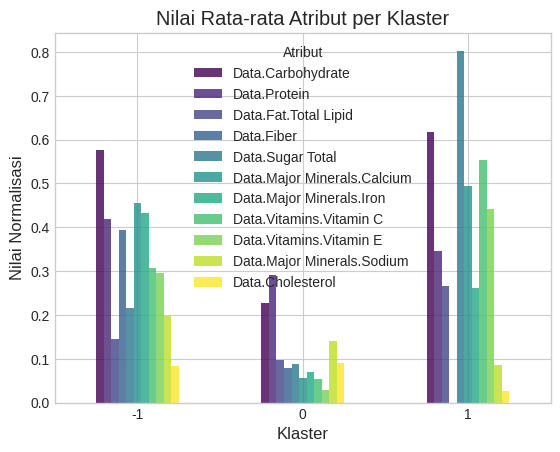

In [ ]:
# -----------------------------------------------
# 7. Visualisasi nilai rata-rata tiap atribut per klaster
# -----------------------------------------------

# Buat DataFrame dari data hasil seleksi fitur
df = pd.DataFrame(data_final_dbscan)

# Tambahkan kolom label hasil clustering DBSCAN
df['Cluster'] = labels

# Hitung nilai rata-rata untuk setiap atribut, dikelompokkan berdasarkan klaster
df_mean = df.groupby('Cluster').mean()

# Inisialisasi ukuran figure plot
plt.figure(figsize=(10, 6))

# Buat barplot dari nilai rata-rata tiap atribut per klaster
df_mean.plot(kind='bar', colormap="viridis", alpha=0.8)

# Penyesuaian tampilan
plt.xlabel("Klaster")
plt.ylabel("Nilai Normalisasi")
plt.title("Nilai Rata-rata Atribut per Klaster")
plt.xticks(rotation=0)
plt.legend(title="Atribut")
plt.show()


<ipython-input-635-279a666ac586>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))


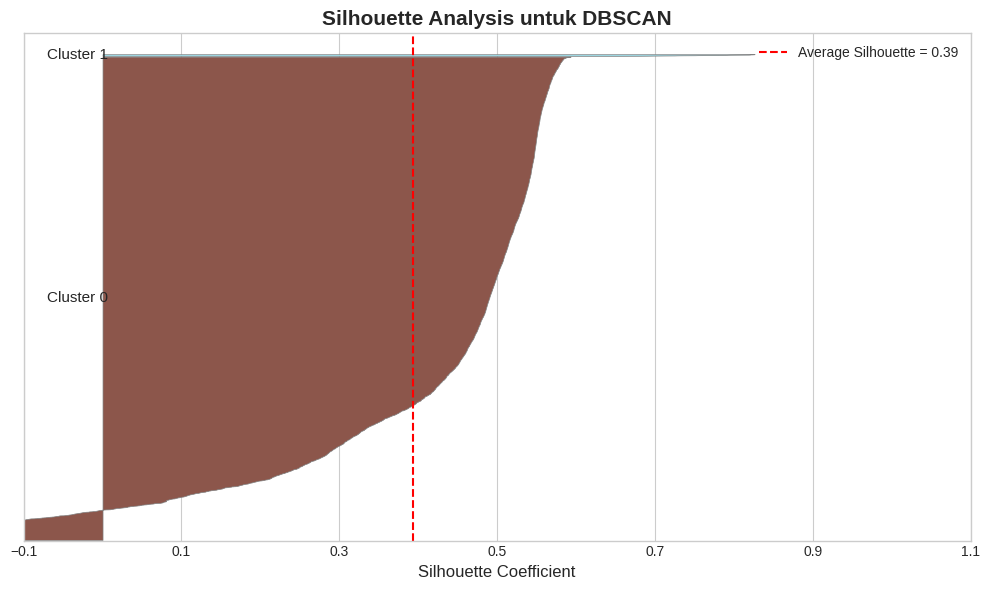

In [ ]:
# -----------------------------------------------
# 8. Visualisasi Silhouette Score per klaster
# -----------------------------------------------
# Hitung skor rata-rata silhouette dan nilai per sampel
silhouette_avg = silhouette_score(data_final_dbscan, labels)
silhouette_vals = silhouette_samples(data_final_dbscan, labels)

# Konfigurasi tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Ambil daftar label klaster unik
unique_clusters = sorted(set(labels))  # Termasuk -1 (noise)
y_lower = 10  # Posisi awal sumbu Y

# Warna klaster
colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))

# Gambar silhouette untuk tiap klaster
for i, cluster_id in enumerate(unique_clusters):
    if cluster_id == -1:
        continue  # Abaikan klaster noise (-1)

    cluster_silhouette_vals = silhouette_vals[labels == cluster_id]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor='gray', linewidth=0.5)

    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {cluster_id}', fontsize=11,
            verticalalignment='center')

    y_lower = y_upper + 10  # Jarak antar klaster

# Garis rata-rata silhouette
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Judul dan label sumbu
ax.set_title('Silhouette Analysis untuk DBSCAN', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Set rentang sumbu X dan Y
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final_dbscan) + (len(unique_clusters) + 1) * 10])
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Legenda
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------------
# 9. Menampilkan contoh data makanan per klaster
# -----------------------------------------------
# Buat DataFrame dari hasil clustering
df = pd.DataFrame(data_final_dbscan)
df['Cluster'] = labels  # Tambahkan label cluster

# Pilih contoh makanan dari setiap cluster
num_samples = 5  # Jumlah contoh per cluster
cluster_groups = df.groupby("Cluster")

# Cetak hasil dalam format yang diinginkan
print("Contoh Makanan per Klaster:\n")

for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue  # Skip cluster noise
    print(f"Cluster {cluster_id}:\n")

    # Pilih contoh makanan secara acak atau berdasarkan urutan awal
    sample_data = cluster_data.sample(min(num_samples, len(cluster_data)), random_state=42)
    print(sample_data.head(num_samples))
    print("\n")


Contoh Makanan per Klaster:

Cluster 0:

      Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Fiber  \
5362               0.58          0.14                  0.09        0.37   
4323               0.00          0.81                  0.08        0.00   
4579               0.14          0.09                  0.02        0.00   
318                0.06          0.07                  0.01        0.09   
5652               0.91          0.21                  0.04        0.26   

      Data.Sugar Total  Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
5362              0.21                         0.04                      0.08   
4323              0.00                         0.01                      0.04   
4579              0.00                         0.09                      0.04   
318               0.04                         0.10                      0.02   
5652              0.00                         0.01                      0.05   

      Data.Vitamins.V

In [ ]:
# -----------------------------------------------
# 10. Evaluasi kualitas klaster setelah seleksi fitur
# -----------------------------------------------
# Hitung Silhouette Score hanya jika terdapat lebih dari 1 klaster (selain noise)
# Jika tidak, beri nilai default -1 yang menandakan kualitas klasterisasi buruk
silhouette = silhouette_score(data_final_dbscan, labels) if len(set(labels)) > 1 else -1

# Hitung Davies-Bouldin Index hanya jika lebih dari 1 klaster terbentuk
# Jika hanya satu klaster (atau noise semua), beri nilai tak hingga
db_index = davies_bouldin_score(data_final_dbscan, labels) if len(set(labels)) > 1 else float('inf')

# Tampilkan hasil evaluasi setelah feature selection berbasis korelasi
print(f"Silhouette Score setelah seleksi fitur: {silhouette:.3f}")
print(f"Davies-Bouldin Index setelah seleksi fitur: {db_index:.3f}")

Silhouette Score setelah seleksi fitur: 0.393
Davies-Bouldin Index setelah seleksi fitur: 1.799


In [ ]:
def analisis_dbscan(data, eps=0.42, min_samples=24):
    n_samples = len(data)  # Hitung jumlah sampel dalam data

    # Lakukan klasterisasi menggunakan DBSCAN
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)

    # Identifikasi outlier (label = -1) dan data yang termasuk klaster
    noise_mask = labels == -1
    cluster_labels = labels[~noise_mask]
    unique_clusters = sorted(set(cluster_labels))  # Klaster unik (tanpa -1)

    # Tampilkan distribusi jumlah klaster dan outlier
    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")

    # Hitung jumlah anggota untuk setiap klaster dan tampilkan
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Analisis outlier secara statistik
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    # Jika tidak ada outlier, akhiri fungsi
    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels

    # Analisis distribusi outlier berdasarkan jarak ke pusat klaster terdekat
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}  # Inisialisasi per klaster

    for i in range(n_samples):
        if noise_mask[i]:
            # Hitung jarak Euclidean ke pusat masing-masing klaster
            dists = []
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]  # Ambil titik dalam klaster
                center = cluster_points.mean(axis=0)       # Hitung pusat klaster
                dist = np.linalg.norm(data.iloc[i] - center)  # Jarak dari outlier ke pusat
                dists.append(dist)
            nearest_cluster = unique_clusters[np.argmin(dists)]  # Klaster terdekat
            outlier_distribution[nearest_cluster] += 1

    # Tampilkan jumlah dan persentase outlier yang paling dekat ke tiap klaster
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels  # Kembalikan label klaster hasil DBSCAN


# Panggil fungsi dengan data hasil seleksi fitur dan parameter DBSCAN
labels_dbscan = analisis_dbscan(pd.DataFrame(data_final_dbscan), eps=0.42, min_samples=24)


Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 281 sampel (3.85%)
Klaster 0: 6994 sampel (95.81%)
Klaster 1: 25 sampel (0.34%)

Outlier Analysis:
Jumlah outlier: 281 sampel
Persentase outlier: 3.85%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 148 outlier (52.67% dari seluruh outlier)
Klaster 1: 133 outlier (47.33% dari seluruh outlier)


In [ ]:
# Asumsi data_final_dbscan dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=0.42, min_samples=24)
labels = model.fit_predict(data_final_dbscan)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Cari klaster terdekat dari titik outlier
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_final_dbscan[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_final_dbscan.iloc[idx] - center)
            dists.append(dist)
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 1, Jarak ke Centroid: 0.997
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 1, Jarak ke Centroid: 1.130
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 1, Jarak ke Centroid: 1.120
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Klaster: 0, Jarak ke Centroid: 1.198
Index: 86, Nama Item: MILK,BUTTERMILK,DRIED, Klaster: 1, Jarak ke Centroid: 1.108
Index: 101, Nama Item: WHEY,ACID,DRIED, Klaster: 1, Jarak ke Centroid: 1.048
Index: 103, Nama Item: WHEY,SWEET,DRIED, Klaster: 1, Jarak ke Centroid: 1.012
Index: 121, Nama Item: EGG,WHOLE,DRIED, Klaster: 0, Jarak ke Centroid: 1.259
Index: 122, Nama Item: EGG,WHL,DRIED,STABILIZED,GLUCOSE RED, Klaster: 0, Jarak ke Centroid: 1.261
Index: 125, Nama Item: EGG,YOLK,DRIED, Klaster: 0, Jarak ke Centroid: 1.302
Index: 132, Nama Item: EGG SUBSTITUTE,POWDER, Klaster: 0, Jarak ke Centroid: 1.246
Index: 145, Nama Item:

## 4. Data Mining Menggunakan DBSCAN (normalisasi Z-Score)

Menggunakan dataset yang sudah dinormalisasi (data_normalisasiZScore)...
Ukuran data_normalisasiZScore: (7300, 12)
Kolom fitur: ['Data.Carbohydrate', 'Data.Protein', 'Data.Fat.Total Lipid', 'Data.Kilocalories', 'Data.Fiber', 'Data.Sugar Total', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin C', 'Data.Vitamins.Vitamin E', 'Data.Major Minerals.Sodium', 'Data.Cholesterol']

Menentukan eps menggunakan K-Distance Graph dengan min_samples = 24...


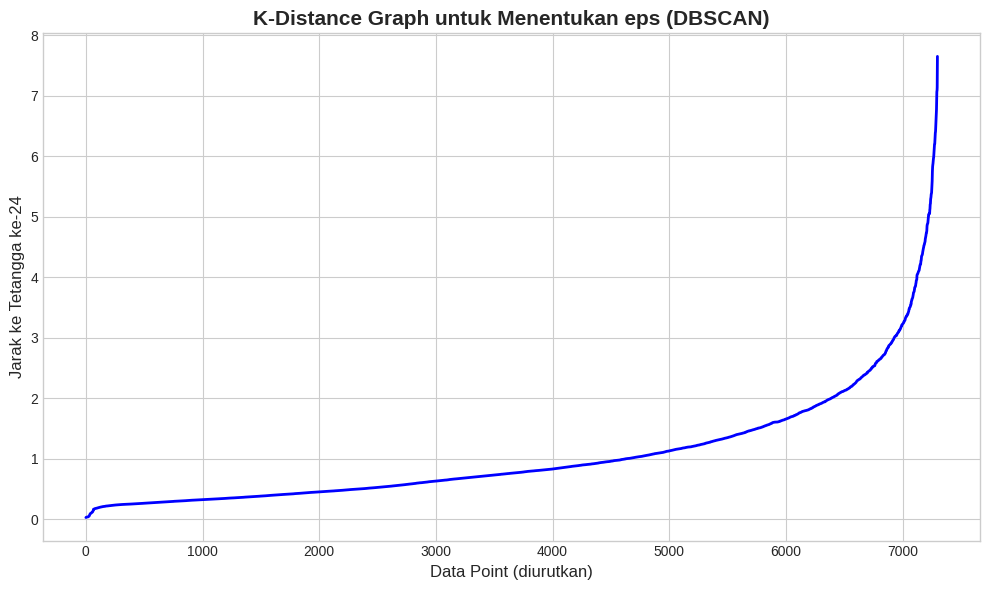


Silakan amati grafik K-Distance di atas.
Temukan titik 'siku' (elbow) pada kurva — itulah nilai eps yang optimal.
Lanjutkan DBSCAN dengan nilai eps tersebut.


In [ ]:
# Menampilkan informasi awal mengenai dataset
print("Menggunakan dataset yang sudah dinormalisasi (data_normalisasiZScore)...")
print("Ukuran data_normalisasiZScore:", data_normalisasiZScore.shape)
print("Kolom fitur:", list(data_normalisasiZScore.columns))

# Langkah 1: Menentukan nilai min_samples
# Biasanya disarankan menggunakan aturan: min_samples = 2 * jumlah fitur
n_features = data_normalisasiZScore.shape[1]
min_samples = 2 * n_features
print(f"\nMenentukan eps menggunakan K-Distance Graph dengan min_samples = {min_samples}...")

# Langkah 2: Membuat model NearestNeighbors untuk menghitung tetangga terdekat
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_normalisasiZScore)

# Langkah 3: Hitung jarak ke tetangga ke-min_samples untuk tiap titik data
distances, indices = neighbors_fit.kneighbors(data_normalisasiZScore)

# Ambil jarak ke tetangga terjauh (kolom terakhir) lalu urutkan untuk plotting
k_distances = np.sort(distances[:, -1])

# Langkah 4: Plot grafik K-Distance
plt.figure(figsize=(10, 6))
plt.plot(k_distances, color='blue', linewidth=2)
plt.title('K-Distance Graph untuk Menentukan eps (DBSCAN)', fontsize=15, fontweight='bold')
plt.xlabel('Data Point (diurutkan)', fontsize=12)
plt.ylabel(f'Jarak ke Tetangga ke-{min_samples}', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Instruksi kepada pengguna untuk menentukan nilai eps
print("\nSilakan amati grafik K-Distance di atas.")
print("Temukan titik 'siku' (elbow) pada kurva — itulah nilai eps yang optimal.")
print("Lanjutkan DBSCAN dengan nilai eps tersebut.")

In [ ]:
def analisis_dbscan(data, eps=1.75, min_samples=24):
    n_samples = len(data)  # Hitung jumlah total sampel

    # DBSCAN fitting
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)  # Dapatkan label hasil clustering

    # Identifikasi noise dan klaster valid
    noise_mask = labels == -1  # Masking untuk noise (label -1)
    cluster_labels = labels[~noise_mask]  # Ambil hanya label yang bukan noise
    unique_clusters = sorted(set(cluster_labels))  # Ambil label klaster unik

    # Cetak distribusi klaster
    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")

    # Hitung jumlah sampel per klaster dan tampilkan
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Analisis outlier
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels

    # Distribusi outlier terhadap klaster terdekat (berdasarkan jarak ke pusat klaster)
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}
    for i in range(n_samples):
        if noise_mask[i]:
            dists = []
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]  # Ambil semua titik dalam klaster
                center = cluster_points.mean(axis=0)  # Hitung pusat klaster
                dist = np.linalg.norm(data.iloc[i] - center)  # Hitung jarak Euclidean
                dists.append(dist)
            nearest_cluster = unique_clusters[np.argmin(dists)]  # Pilih klaster terdekat
            outlier_distribution[nearest_cluster] += 1

    # Tampilkan distribusi outlier ke klaster terdekat
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels

# Panggil fungsi
labels_dbscan = analisis_dbscan(pd.DataFrame(data_normalisasiZScore), eps=1.75, min_samples=24)


Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 676 sampel (9.26%)
Klaster 0: 45 sampel (0.62%)
Klaster 1: 6495 sampel (88.97%)
Klaster 2: 30 sampel (0.41%)
Klaster 3: 27 sampel (0.37%)
Klaster 4: 27 sampel (0.37%)

Outlier Analysis:
Jumlah outlier: 676 sampel
Persentase outlier: 9.26%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 118 outlier (17.46% dari seluruh outlier)
Klaster 1: 177 outlier (26.18% dari seluruh outlier)
Klaster 2: 54 outlier (7.99% dari seluruh outlier)
Klaster 3: 203 outlier (30.03% dari seluruh outlier)
Klaster 4: 124 outlier (18.34% dari seluruh outlier)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# Asumsi data_normalisasiZScore dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=1.75, min_samples=24)
labels = model.fit_predict(data_normalisasiZScore)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Cari klaster terdekat dari titik outlier
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_normalisasiZScore[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_normalisasiZScore.iloc[idx] - center)
            dists.append(dist)
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 0, Nama Item: BUTTER,WITH SALT, Klaster: 4, Jarak ke Centroid: 5.657
Index: 1, Nama Item: BUTTER,WHIPPED,WITH SALT, Klaster: 4, Jarak ke Centroid: 5.892
Index: 2, Nama Item: BUTTER OIL,ANHYDROUS, Klaster: 4, Jarak ke Centroid: 6.715
Index: 18, Nama Item: CHEESE,FETA, Klaster: 0, Jarak ke Centroid: 2.072
Index: 20, Nama Item: CHEESE,GJETOST, Klaster: 0, Jarak ke Centroid: 3.091
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 2.956
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 3.056
Index: 38, Nama Item: CHEESE,ROQUEFORT, Klaster: 0, Jarak ke Centroid: 2.759
Index: 82, Nama Item: MILK,DRY,WHOLE, Klaster: 0, Jarak ke Centroid: 3.811
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 5.206
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 5.195
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Kl

### Feature Selection menggunakan Silhouette dan DBI

In [ ]:
# 1. Fungsi untuk evaluasi baseline dengan semua fitur, dan evaluasi pengaruh penghapusan tiap fitur
def evaluate_features(data, eps=1.75, min_samples=24):
    # Inisialisasi dan fitting model DBSCAN pada data lengkap (baseline)
    baseline_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    baseline_labels = baseline_dbscan.labels_

    # Evaluasi hanya dilakukan jika hasil klaster lebih dari 1 klaster unik
    if len(set(baseline_labels)) > 1:
        baseline_sil = silhouette_score(data, baseline_labels)
        baseline_db = davies_bouldin_score(data, baseline_labels)
    else:
        # Jika hanya satu klaster (atau semuanya noise), fallback ke nilai buruk
        baseline_sil, baseline_db = -1, float('inf')

    # Tampilkan hasil evaluasi baseline
    print(f"Baseline (Semua fitur) -> Silhouette: {baseline_sil:.3f}, Davies-Bouldin: {baseline_db:.3f}")

    result = []
    # Evaluasi performa clustering jika satu fitur dihapus (Leave-One-Feature-Out)
    for fitur in data.columns:
        subset = data.drop(columns=[fitur])  # Data tanpa 1 fitur
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(subset)

        # Hitung metrik evaluasi jika valid (lebih dari 1 klaster unik)
        if len(set(labels)) > 1:
            sil = silhouette_score(subset, labels)
            db = davies_bouldin_score(subset, labels)
        else:
            sil, db = -1, float('inf')

        # Simpan hasil evaluasi untuk fitur ini
        result.append({
            'fitur_dihapus': fitur,
            'silhouette': sil,
            'davies_bouldin': db,
            'delta_silhouette': sil - baseline_sil,  # Perubahan Silhouette dibanding baseline
            'delta_db': db - baseline_db  # Perubahan Davies-Bouldin dibanding baseline
        })

    # Kembalikan hasil sebagai DataFrame, diurutkan dari peningkatan Silhouette terbesar
    return pd.DataFrame(result).sort_values(by='delta_silhouette', ascending=False)

# 2. Jalankan evaluasi otomatis pada data_normalisasiZScore
hasil_evaluasi = evaluate_features(pd.DataFrame(data_normalisasiZScore))

# 3. Pilih fitur-fitur yang jika dihapus justru meningkatkan Silhouette dan menurunkan DB Index
fitur_dihapus_otomatis = hasil_evaluasi[
    (hasil_evaluasi['delta_silhouette'] > 0) &  # Silhouette naik
    (hasil_evaluasi['delta_db'] < 0)  # Davies-Bouldin turun
]['fitur_dihapus'].tolist()

# 4. Buat daftar fitur final yang akan dipakai (dengan menghapus fitur yang buruk)
fitur_final = [f for f in pd.DataFrame(data_normalisasiZScore).columns if f not in fitur_dihapus_otomatis]
data_final = pd.DataFrame(data_normalisasiZScore)[fitur_final]  # Dataset akhir dengan fitur terbaik

# Tampilkan hasil akhir seleksi fitur
print(f"\nFitur yang dihapus otomatis: {fitur_dihapus_otomatis}")
print(f"Jumlah fitur tersisa: {len(fitur_final)}")
print(f"Fitur tersisa: {fitur_final}")

Baseline (Semua fitur) -> Silhouette: 0.289, Davies-Bouldin: 1.565

Fitur yang dihapus otomatis: ['Data.Fiber', 'Data.Protein', 'Data.Sugar Total', 'Data.Cholesterol', 'Data.Vitamins.Vitamin C']
Jumlah fitur tersisa: 7
Jumlah fitur tersisa: ['Data.Carbohydrate', 'Data.Fat.Total Lipid', 'Data.Kilocalories', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Iron', 'Data.Vitamins.Vitamin E', 'Data.Major Minerals.Sodium']


In [ ]:
# Terapkan algoritma DBSCAN pada data hasil seleksi fitur (data_final)
# Parameter eps dan min_samples ditentukan berdasarkan analisis sebelumnya (misalnya dari K-Distance Graph)
labels = DBSCAN(eps=1.75, min_samples=24).fit_predict(data_final)

# Hitung jumlah klaster yang terbentuk, dengan mengabaikan label -1 (outlier/noise)
# Jika -1 (noise) ada di label, maka kurangi 1 dari jumlah total label unik
print(f"Jumlah cluster ditemukan: {len(set(labels)) - (1 if -1 in labels else 0)}")

Jumlah cluster ditemukan: 2


<Figure size 1000x600 with 0 Axes>

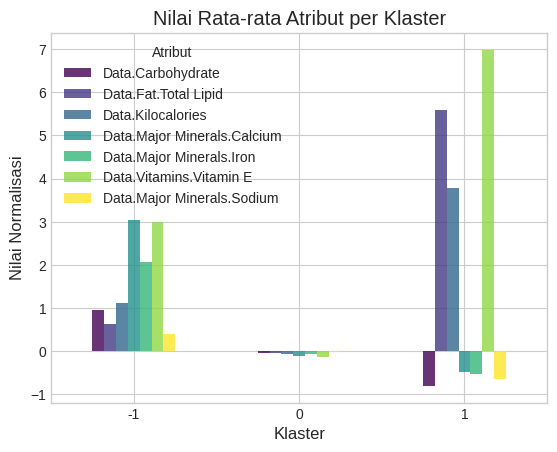

In [ ]:
# Buat DataFrame dari data_final dan tambahkan kolom 'Cluster' hasil label DBSCAN
df = pd.DataFrame(data_final)
df['Cluster'] = labels

# Hitung rata-rata setiap atribut (fitur) untuk masing-masing klaster
df_mean = df.groupby('Cluster').mean()

# Buat barplot untuk menunjukkan nilai rata-rata atribut di tiap klaster
plt.figure(figsize=(10, 6))  # Atur ukuran plot
df_mean.plot(kind='bar', colormap="viridis", alpha=0.8)  # Plot bar dengan colormap viridis

# Tambahkan label dan judul ke sumbu X dan Y serta judul grafik
plt.xlabel("Klaster")
plt.ylabel("Nilai Normalisasi")
plt.title("Nilai Rata-rata Atribut per Klaster")

# Rotasi label sumbu X agar lebih mudah dibaca
plt.xticks(rotation=0)

# Tampilkan legenda dengan judul "Atribut"
plt.legend(title="Atribut")

# Tampilkan grafik
plt.show()

<ipython-input-664-0530ccc5c370>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))


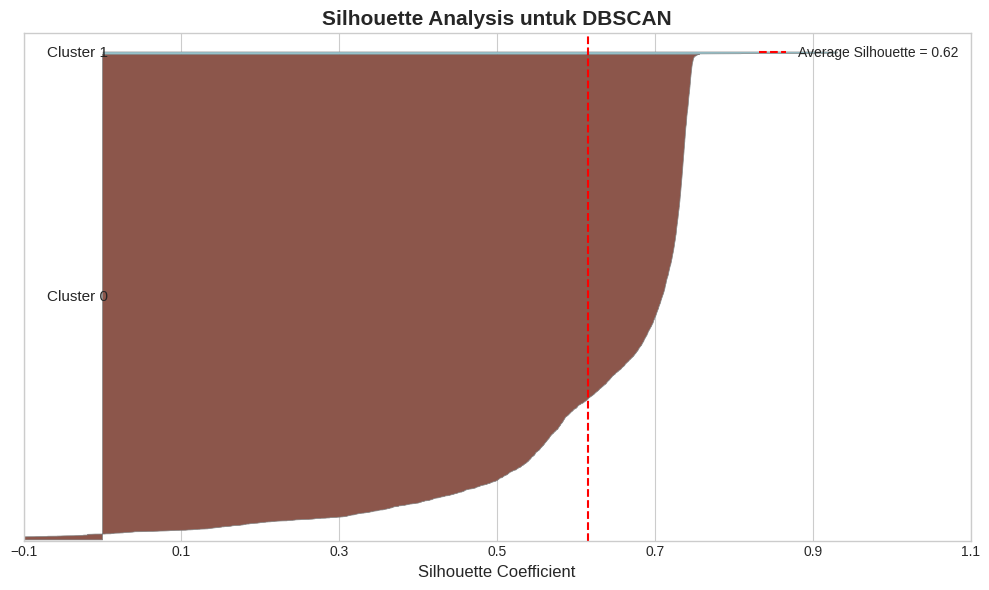

In [ ]:
# Hitung nilai rata-rata silhouette keseluruhan dan nilai silhouette masing-masing data point
silhouette_avg = silhouette_score(data_final, labels)
silhouette_vals = silhouette_samples(data_final, labels)

# Konfigurasi gaya plot dan ukuran figure
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Dapatkan label klaster unik (termasuk -1 jika ada noise)
unique_clusters = sorted(set(labels))
y_lower = 10  # Inisialisasi posisi bawah plot Y

# Buat palet warna untuk setiap klaster
colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))

# Iterasi setiap klaster untuk membuat siluet bar
for i, cluster_id in enumerate(unique_clusters):
    if cluster_id == -1:
        continue  # Lewati noise (label -1)

    # Ambil dan urutkan nilai silhouette untuk klaster saat ini
    cluster_silhouette_vals = silhouette_vals[labels == cluster_id]
    cluster_silhouette_vals.sort()

    # Hitung batas atas untuk sumbu Y
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Plot area silhouette untuk klaster tersebut
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor='gray', linewidth=0.5)

    # Tambahkan label teks di tengah area klaster
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {cluster_id}', fontsize=11,
            verticalalignment='center')

    # Update posisi y_lower untuk klaster berikutnya
    y_lower = y_upper + 10  # Tambahkan jarak antar klaster

# Garis vertikal merah menunjukkan rata-rata silhouette score keseluruhan
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Konfigurasi tampilan plot
ax.set_title('Silhouette Analysis untuk DBSCAN', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Atur batas dan tampilan sumbu
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final) + (len(unique_clusters) + 1) * 10])
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Tambahkan legenda dan tampilkan plot
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Hitung Silhouette Score hanya jika terdapat lebih dari satu klaster
silhouette = silhouette_score(data_final, labels) if len(set(labels)) > 1 else -1

# Hitung Davies-Bouldin Index hanya jika terdapat lebih dari satu klaster
db_index = davies_bouldin_score(data_final, labels) if len(set(labels)) > 1 else float('inf')

# Tampilkan hasil evaluasi metrik clustering
print(f"Silhouette Score setelah seleksi fitur: {silhouette:.3f}")
print(f"Davies-Bouldin Index setelah seleksi fitur: {db_index:.3f}")

Silhouette Score setelah seleksi fitur: 0.616
Davies-Bouldin Index setelah seleksi fitur: 1.120


In [ ]:
# Buat DataFrame dari hasil clustering
df = pd.DataFrame(data_final)
df['Cluster'] = labels  # Tambahkan label cluster

# Pilih contoh makanan dari setiap cluster
num_samples = 5  # Jumlah contoh per cluster
cluster_groups = df.groupby("Cluster")

# Cetak hasil dalam format yang diinginkan
print("Contoh Makanan per Klaster:\n")

for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue  # Skip cluster noise
    print(f"Cluster {cluster_id}:\n")

    # Pilih contoh makanan secara acak atau berdasarkan urutan awal
    sample_data = cluster_data.sample(min(num_samples, len(cluster_data)), random_state=42)
    print(sample_data.head(num_samples))
    print("\n")

Contoh Makanan per Klaster:

Cluster 0:

      Data.Carbohydrate  Data.Fat.Total Lipid  Data.Kilocalories  \
3630              -0.04                  3.05               2.43   
5563               2.25                 -0.15               1.19   
6374               0.27                  0.06               0.29   
6570              -0.31                 -0.08              -0.28   
3811              -0.81                  1.31               0.70   

      Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
3630                        -0.08                      0.82   
5563                         0.88                     -0.54   
6374                         0.99                     -0.08   
6570                        -0.06                     -0.39   
3811                        -0.32                     -0.21   

      Data.Vitamins.Vitamin E  Data.Major Minerals.Sodium  Cluster  
3630                    -0.31                        0.84        0  
5563                    -0.31    

In [ ]:
# Fungsi untuk Analisis Hasil Clustering DBSCAN
# Termasuk identifikasi klaster, noise, dan distribusi outlier
def analisis_dbscan(data, eps=1.75, min_samples=24):
    n_samples = len(data)

    # DBSCAN fit
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)  # Menghasilkan label untuk setiap sampel

    # Identifikasi noise dan klaster
    noise_mask = labels == -1  # Penanda sampel yang dianggap outlier
    cluster_labels = labels[~noise_mask]  # Label klaster (tanpa noise)
    unique_clusters = sorted(set(cluster_labels))  # Daftar klaster unik

    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")


    # Tampilkan jumlah sampel pada setiap klaster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Outlier Analysis
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    # Jika tidak ada outlier, keluar dari fungsi
    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels

    # Mengukur seberapa dekat outlier ke pusat klaster
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}
    for i in range(n_samples):
        if noise_mask[i]:
            # Cari klaster terdekat dari titik outlier (menggunakan jarak Euclidean ke pusat klaster)
            dists = []
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]  # Titik-titik dalam klaster
                center = cluster_points.mean(axis=0)  # Hitung pusat klaster
                dist = np.linalg.norm(data.iloc[i] - center)  # Jarak Euclidean ke pusat
                dists.append(dist)
            nearest_cluster = unique_clusters[np.argmin(dists)]
            outlier_distribution[nearest_cluster] += 1

    # Tampilkan distribusi outlier ke masing-masing klaster
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels  # Kembalikan label hasil clustering

# Panggil fungsi
labels_dbscan = analisis_dbscan(pd.DataFrame(data_final), eps=1.75, min_samples=24)



Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 242 sampel (3.32%)
Klaster 0: 7027 sampel (96.26%)
Klaster 1: 31 sampel (0.42%)

Outlier Analysis:
Jumlah outlier: 242 sampel
Persentase outlier: 3.32%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 178 outlier (73.55% dari seluruh outlier)
Klaster 1: 64 outlier (26.45% dari seluruh outlier)


In [ ]:
# Asumsi data_final_threshold dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=1.75, min_samples=24)
labels = model.fit_predict(data_final)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Cari klaster terdekat dari titik outlier
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_final_threshold[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_final_threshold.iloc[idx] - center)
            dists.append(dist)
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')
        # Gunakan data_bersih untuk mendapatkan 'Description', fallback ke 'Item_{idx}' jika tidak ada
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 7.847
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 7.855
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 7.080
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 7.049
Index: 86, Nama Item: MILK,BUTTERMILK,DRIED, Klaster: 0, Jarak ke Centroid: 7.000
Index: 101, Nama Item: WHEY,ACID,DRIED, Klaster: 0, Jarak ke Centroid: 6.988
Index: 103, Nama Item: WHEY,SWEET,DRIED, Klaster: 0, Jarak ke Centroid: 6.262
Index: 125, Nama Item: EGG,YOLK,DRIED, Klaster: 0, Jarak ke Centroid: 7.734
Index: 134, Nama Item: CHEESE,PARMESAN,SHREDDED, Klaster: 0, Jarak ke Centroid: 7.998
Index: 162, Nama Item: PARMESAN CHS TOPPING,FAT FREE, Klaster: 0, Jarak ke Centroid: 6.593
Index: 167, Nama Item: KRAFT FREE SINGLES AMERICAN NONFAT PAST PROCESS CHS PRODUCT, Klaster: 0, J

### Feature Selection menggunakan Threshold Correlation

In [ ]:
# ------------------------------
# 5. FEATURE SELECTION: CORRELATION FILTERING DENGAN PENCARIAN THRESHOLD TERBAIK
# ------------------------------

# Tujuan: Mencari threshold korelasi terbaik untuk menghapus fitur redundant
# dan meningkatkan kualitas clustering DBSCAN berdasarkan Silhouette & DB Index
def dbscan_correlation_filtering_auto(data, thresholds=None, eps=1.75, min_samples=24):
    if thresholds is None:
        thresholds = np.arange(0.5, 0.96, 0.05)  # Range default threshold korelasi

    hasil_evaluasi = []  # Simpan hasil evaluasi untuk tiap threshold

    print("Evaluasi DBSCAN untuk berbagai threshold korelasi...\n")
    for threshold in thresholds:
        # Korelasi
        corr_matrix = data.corr().abs()  # Matriks korelasi absolut
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Segitiga atas
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]  # Fitur dengan korelasi tinggi
        data_filtered = data.drop(columns=to_drop)  # Data setelah fitur redundant dihapus

        # DBSCAN
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data_filtered)

        # Evaluasi
        f len(set(labels)) > 1:
            sil = silhouette_score(data_filtered, labels)
            db = davies_bouldin_score(data_filtered, labels)
        else:
            sil, db = -1, float('inf')  # Fallback jika hanya 1 klaster terbentuk

        hasil_evaluasi.append({
            'threshold': threshold,
            'n_features': data_filtered.shape[1],
            'n_dropped': len(to_drop),
            'silhouette': sil,
            'davies_bouldin': db
        })

        print(f"Threshold: {threshold:.2f} | Dropped: {len(to_drop)} | Silhouette: {sil:.3f} | DBI: {db:.3f}")

    # Penentuan Threshold Terbaik
    # Berdasarkan peringkat kombinasi dari Silhouette & DBI
    df_eval = pd.DataFrame(hasil_evaluasi)

    # Cari threshold terbaik
    df_eval['sil_rank'] = df_eval['silhouette'].rank(ascending=False)
    df_eval['dbi_rank'] = df_eval['davies_bouldin'].rank(ascending=True)
    df_eval['total_rank'] = df_eval['sil_rank'] + df_eval['dbi_rank']
    best_threshold = df_eval.sort_values(by='total_rank').iloc[0]['threshold']

    print(f"\nThreshold terbaik berdasarkan DBSCAN: {best_threshold:.2f}")

    # Terapkan threshold terbaik untuk final data
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
    data_final = data.drop(columns=to_drop)

    # Evaluasi final
    final_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data_final)
    if len(set(final_labels)) > 1:
        sil_final = silhouette_score(data_final, final_labels)
        db_final = davies_bouldin_score(data_final, final_labels)
    else:
        sil_final, db_final = -1, float('inf')

    print(f"\nEvaluasi Akhir DBSCAN:")
    print(f"Jumlah fitur tersisa: {data_final.shape[1]}")
    print(f"Silhouette Score: {sil_final:.3f}")
    print(f"Davies-Bouldin Index: {db_final:.3f}")

    return data_final, df_eval  # Kembalikan data akhir dan hasil evaluasi semua threshold

# Panggil fungsi
data_final_dbscan, evaluasi_dbscan_thresholds = dbscan_correlation_filtering_auto(pd.DataFrame(data_normalisasiZScore))

Evaluasi DBSCAN untuk berbagai threshold korelasi...

Threshold: 0.50 | Dropped: 3 | Silhouette: 0.492 | DBI: 1.405
Threshold: 0.55 | Dropped: 3 | Silhouette: 0.492 | DBI: 1.405
Threshold: 0.60 | Dropped: 2 | Silhouette: 0.390 | DBI: 1.499
Threshold: 0.65 | Dropped: 1 | Silhouette: 0.265 | DBI: 1.549
Threshold: 0.70 | Dropped: 1 | Silhouette: 0.265 | DBI: 1.549
Threshold: 0.75 | Dropped: 1 | Silhouette: 0.265 | DBI: 1.549
Threshold: 0.80 | Dropped: 0 | Silhouette: 0.289 | DBI: 1.565
Threshold: 0.85 | Dropped: 0 | Silhouette: 0.289 | DBI: 1.565
Threshold: 0.90 | Dropped: 0 | Silhouette: 0.289 | DBI: 1.565
Threshold: 0.95 | Dropped: 0 | Silhouette: 0.289 | DBI: 1.565

Threshold terbaik berdasarkan DBSCAN: 0.50

Evaluasi Akhir DBSCAN:
Jumlah fitur tersisa: 9
Silhouette Score: 0.492
Davies-Bouldin Index: 1.405


In [ ]:
# -----------------------------------------------
# 9. Menentukan jumlah cluster dari hasil feature selection
# -----------------------------------------------
# Jalankan DBSCAN pada data hasil seleksi fitur
labels = DBSCAN(eps=1.75, min_samples=24).fit_predict(data_final_dbscan)

# Hitung jumlah klaster aktual (tidak termasuk noise/outlier yang diberi label -1)
print(f"Jumlah cluster ditemukan: {len(set(labels)) - (1 if -1 in labels else 0)}")

Jumlah cluster ditemukan: 3


<Figure size 1000x600 with 0 Axes>

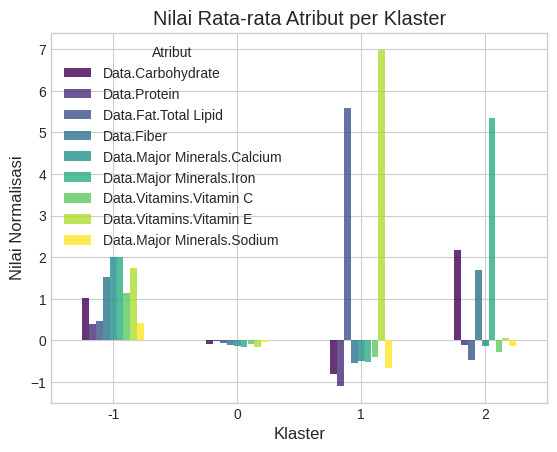

In [ ]:
# -----------------------------------------------
# 10. Visualisasi nilai rata-rata tiap atribut per klaster
# -----------------------------------------------
# Konversi data akhir menjadi DataFrame dan tambahkan label klaster hasil DBSCAN
df = pd.DataFrame(data_final_dbscan)
df['Cluster'] = labels  # Menambahkan kolom "Cluster" ke DataFrame

# Hitung nilai rata-rata dari setiap atribut untuk masing-masing klaster
df_mean = df.groupby('Cluster').mean()

# Visualisasi: Barplot nilai rata-rata atribut per klaster
plt.figure(figsize=(10, 6))
df_mean.plot(kind='bar', colormap="viridis", alpha=0.8)

# Konfigurasi plot
plt.xlabel("Klaster")
plt.ylabel("Nilai Normalisasi")
plt.title("Nilai Rata-rata Atribut per Klaster")
plt.xticks(rotation=0)
plt.legend(title="Atribut")
plt.show()

<ipython-input-672-798d7ace4090>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))


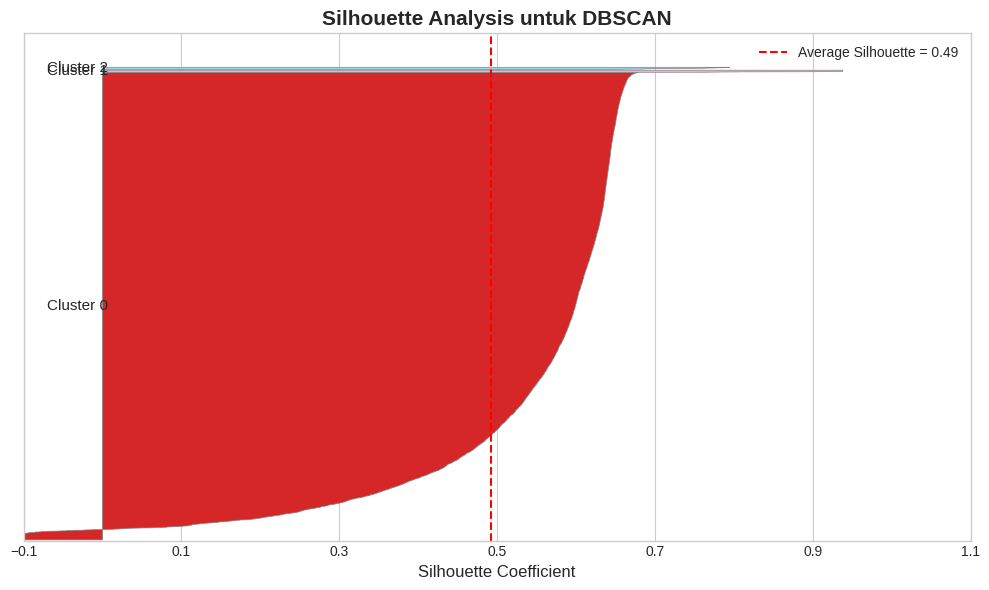

In [ ]:
# -----------------------------------------------
# 11. Visualisasi Silhouette Score per klaster
# -----------------------------------------------
# Hitung skor silhouette rata-rata untuk seluruh data
silhouette_avg = silhouette_score(data_final_dbscan, labels)

# Hitung skor silhouette individual untuk setiap sampel
silhouette_vals = silhouette_samples(data_final_dbscan, labels)

# Setup gaya visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Dapatkan klaster unik (termasuk noise jika ada)
unique_clusters = sorted(set(labels))
y_lower = 10  # Awal posisi vertikal untuk plot pertama

# Warna berbeda untuk tiap klaster
colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))

# Loop setiap klaster dan visualisasikan silhouette individunya
for i, cluster_id in enumerate(unique_clusters):
    if cluster_id == -1:
        continue  # Lewati noise cluster

    # Ambil dan urutkan nilai silhouette untuk klaster saat ini
    cluster_silhouette_vals = silhouette_vals[labels == cluster_id]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Visualisasi silhouette untuk klaster ini
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor='gray', linewidth=0.5)

    # Label klaster di tengah area vertikal
    ax.text(-0.07, y_lower + 0.5 * size_cluster_i,
            f'Cluster {cluster_id}', fontsize=11,
            verticalalignment='center')

    y_lower = y_upper + 10  # Tambahkan spasi vertikal antar klaster

# Garis vertikal sebagai indikator rata-rata silhouette score keseluruhan
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5,
           label=f'Average Silhouette = {silhouette_avg:.2f}')

# Konfigurasi tampilan plot
ax.set_title('Silhouette Analysis untuk DBSCAN', fontsize=15, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('')

# Batas dan label sumbu
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(data_final_dbscan) + (len(unique_clusters) + 1) * 10])
ax.set_yticks([])  # Tidak tampilkan skala y (karena tidak penting di sini)
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Tampilkan legenda
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------------
# 12. Menampilkan contoh data makanan per klaster
# -----------------------------------------------
# Buat DataFrame dari hasil clustering
df = pd.DataFrame(data_final_dbscan)
df['Cluster'] = labels  # Tambahkan label cluster

# Pilih contoh makanan dari setiap cluster
num_samples = 5  # Jumlah contoh per cluster
cluster_groups = df.groupby("Cluster")

# Cetak hasil dalam format yang diinginkan
print("Contoh Makanan per Klaster:\n")

for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue  # Skip cluster noise
    print(f"Cluster {cluster_id}:\n")

    # Pilih contoh makanan secara acak atau berdasarkan urutan awal
    sample_data = cluster_data.sample(min(num_samples, len(cluster_data)), random_state=42)
    print(sample_data.head(num_samples))
    print("\n")


Contoh Makanan per Klaster:

Cluster 0:

      Data.Carbohydrate  Data.Protein  Data.Fat.Total Lipid  Data.Fiber  \
184               -0.68          1.42                  0.62       -0.55   
44                -0.50          0.91                  0.95       -0.55   
45                -0.52          0.78                  1.00       -0.55   
7239              -0.75          1.17                  1.39       -0.55   
151               -0.60          1.10                  1.29       -0.55   

      Data.Major Minerals.Calcium  Data.Major Minerals.Iron  \
184                          6.29                     -0.51   
44                           3.17                     -0.37   
45                           3.71                     -0.42   
7239                         4.05                     -0.46   
151                          4.30                     -0.44   

      Data.Vitamins.Vitamin C  Data.Vitamins.Vitamin E  \
184                     -0.40                    -0.23   
44           

In [ ]:
# -----------------------------------------------
# 13. Evaluasi kualitas klaster setelah seleksi fitur
# -----------------------------------------------
# Hitung Silhouette Score jika jumlah klaster lebih dari 1
# Nilai ini mengukur seberapa baik tiap titik cocok dengan klasternya dibandingkan dengan klaster lain
silhouette = silhouette_score(data_final_dbscan, labels) if len(set(labels)) > 1 else -1

# Hitung Davies-Bouldin Index jika jumlah klaster lebih dari 1
# Nilai ini mengevaluasi rasio antara jarak antar klaster dengan sebaran dalam klaster (lebih rendah lebih baik)
db_index = davies_bouldin_score(data_final_dbscan, labels) if len(set(labels)) > 1 else float('inf')

# Tampilkan hasil evaluasi
print(f"Silhouette Score setelah seleksi fitur: {silhouette:.3f}")
print(f"Davies-Bouldin Index setelah seleksi fitur: {db_index:.3f}")

Silhouette Score setelah seleksi fitur: 0.492
Davies-Bouldin Index setelah seleksi fitur: 1.405


In [ ]:
def analisis_dbscan(data, eps=1.75, min_samples=24):
    n_samples = len(data)

    # DBSCAN fit
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)

    # Identifikasi noise dan klaster
    noise_mask = labels == -1  # Masking untuk outlier/noise
    cluster_labels = labels[~noise_mask]  # Ambil label klaster valid (bukan noise)
    unique_clusters = sorted(set(cluster_labels))  # Klaster unik tanpa noise

    print(f"\nDistribusi Klaster dengan {n_samples} sampel:")
    if np.sum(noise_mask) > 0:
        print(f"Noise (Outlier): {np.sum(noise_mask)} sampel ({(np.sum(noise_mask) / n_samples) * 100:.2f}%)")
    else:
        print("Tidak ada noise terdeteksi.")

    # Hitung jumlah sampel per klaster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Klaster {i}: {count} sampel ({(count / n_samples) * 100:.2f}%)")

    # Outlier Analysis
    print("\nOutlier Analysis:")
    n_outliers = np.sum(noise_mask)
    outlier_percentage = (n_outliers / n_samples) * 100
    print(f"Jumlah outlier: {n_outliers} sampel")
    print(f"Persentase outlier: {outlier_percentage:.2f}%")

    if n_outliers == 0:
        print("\nTidak ada outlier untuk dianalisis.")
        return labels


    # Distribusi outlier berdasarkan kedekatan ke pusat klaster terdekat
    print("\nDistribusi Outlier (berdasarkan kedekatan ke klaster):")
    outlier_distribution = {i: 0 for i in unique_clusters}
    for i in range(n_samples):
        if noise_mask[i]:
            dists = []
            # Hitung jarak outlier ke pusat tiap klaster
            for cluster in unique_clusters:
                cluster_points = data[labels == cluster]
                center = cluster_points.mean(axis=0)
                dist = np.linalg.norm(data.iloc[i] - center)
                dists.append(dist)
            # Tentukan klaster terdekat
            nearest_cluster = unique_clusters[np.argmin(dists)]
            outlier_distribution[nearest_cluster] += 1

    # Cetak distribusi outlier terhadap klaster terdekat
    for cluster, out_count in outlier_distribution.items():
        out_pct_total = (out_count / n_outliers) * 100
        print(f"Klaster {cluster}: {out_count} outlier ({out_pct_total:.2f}% dari seluruh outlier)")

    return labels

# Panggil fungsi
labels_dbscan = analisis_dbscan(pd.DataFrame(data_final_dbscan), eps=1.75, min_samples=24)



Distribusi Klaster dengan 7300 sampel:
Noise (Outlier): 464 sampel (6.36%)
Klaster 0: 6773 sampel (92.78%)
Klaster 1: 31 sampel (0.42%)
Klaster 2: 32 sampel (0.44%)

Outlier Analysis:
Jumlah outlier: 464 sampel
Persentase outlier: 6.36%

Distribusi Outlier (berdasarkan kedekatan ke klaster):
Klaster 0: 232 outlier (50.00% dari seluruh outlier)
Klaster 1: 62 outlier (13.36% dari seluruh outlier)
Klaster 2: 170 outlier (36.64% dari seluruh outlier)


In [ ]:
# Asumsi data_final_threshold dan data_bersih sudah didefinisikan
# Inisialisasi dan fit model DBSCAN
model = DBSCAN(eps=1.75, min_samples=24)
labels = model.fit_predict(data_final_dbscan)

# Identifikasi noise (outlier) dengan label -1
noise_mask = labels == -1
outliers = np.where(noise_mask)[0]

# Identifikasi klaster yang valid (non-noise)
cluster_labels = labels[~noise_mask]
unique_clusters = sorted(set(cluster_labels))

# Tampilkan detail instance error (outlier)
print("\nDetail Instance Error (Outlier):")
if len(outliers) > 0:
    print("Daftar item yang dianggap outlier:")
    for idx in outliers:
        # Hitung jarak dari outlier ke setiap centroid klaster
        dists = []
        for cluster in unique_clusters:
            cluster_points = data_final_threshold[labels == cluster]
            center = cluster_points.mean(axis=0)
            dist = np.linalg.norm(data_final_threshold.iloc[idx] - center)
            dists.append(dist)

        # Tentukan klaster terdekat dan jarak terpendek
        nearest_cluster = unique_clusters[np.argmin(dists)] if unique_clusters else -1
        distance = min(dists) if dists else float('nan')

        # Ambil nama item dari kolom 'Description' jika tersedia
        item_name = data_bersih.iloc[idx]['Description'] if 'Description' in data_bersih.columns else f"Item_{idx}"

        # Cetak detail outlier
        print(f"Index: {idx}, Nama Item: {item_name}, Klaster Terdekat: {nearest_cluster}, Jarak ke Centroid: {distance:.3f}")
else:
    print("Tidak ada outlier yang ditemukan.")


Detail Instance Error (Outlier):
Daftar item yang dianggap outlier:
Index: 31, Nama Item: CHEESE,PARMESAN,GRATED, Klaster: 0, Jarak ke Centroid: 7.872
Index: 32, Nama Item: CHEESE,PARMESAN,HARD, Klaster: 0, Jarak ke Centroid: 7.879
Index: 83, Nama Item: MILK,DRY,NONFAT,REG,WO/ VIT A, Klaster: 0, Jarak ke Centroid: 7.114
Index: 84, Nama Item: MILK,DRY,NONFAT,INST,W/ VIT A, Klaster: 0, Jarak ke Centroid: 7.082
Index: 85, Nama Item: MILK,DRY,NONFAT,CA RED, Klaster: 0, Jarak ke Centroid: 5.718
Index: 86, Nama Item: MILK,BUTTERMILK,DRIED, Klaster: 0, Jarak ke Centroid: 7.031
Index: 101, Nama Item: WHEY,ACID,DRIED, Klaster: 0, Jarak ke Centroid: 7.027
Index: 103, Nama Item: WHEY,SWEET,DRIED, Klaster: 0, Jarak ke Centroid: 6.301
Index: 121, Nama Item: EGG,WHOLE,DRIED, Klaster: 0, Jarak ke Centroid: 7.230
Index: 122, Nama Item: EGG,WHL,DRIED,STABILIZED,GLUCOSE RED, Klaster: 0, Jarak ke Centroid: 7.133
Index: 125, Nama Item: EGG,YOLK,DRIED, Klaster: 0, Jarak ke Centroid: 7.741
Index: 132, Nama